📚🩺 Insurance 회귀 분석 캡스톤

| 아이티윌 데이터분석 부트캠프 52기 이광호 강사 (leekh4232@gmail.com
)

“왜 어떤 사람의 의료보험 청구 비용은 높고, 어떤 사람의 비용은 낮을까?”

의료 비용은 개인의 건강 상태를 반영하기도 하지만, 나이, 성별, 거주 지역, 생활습관에 따라 체계적으로 달라집니다.
특히 흡연 여부는 의료비를 얼마나 크게 변화시킬까? 젊은 사람도 흡연자라면 높은 비용을 지불할까?

이번 캡스톤 과제에서는 Insurance 데이터셋을 활용하여 개인의 인구학적·건강 특성이 의료보험 청구 비용을 어떤 구조로 설명하는지 회귀모형을 통해 단계적으로 탐구합니다.

이 과제의 목표는 예측 정확도를 높이는 것이 아니라, **“의료 비용 불평등은 어떤 논리로 형성되는가”**를 수치와 언어로 설명하는 것입니다.

※ 본 과제는 팀 / 개인 단위 모두 수행 가능합니다.

### 라이브러리 참조

In [1]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from pandas.api.types import CategoricalDtype
import pandas as pd
from scipy.stats import t, normaltest, bartlett, levene, ttest_ind
import pingouin as pg
from pandas import DataFrame, get_dummies
# 선형회귀를 위한 참조
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 결과 검정을 위한 참조
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson


# VIF값을 계산하기 위한 참조
from statsmodels.stats.outliers_influence import variance_inflation_factor


from statannotations.Annotator import Annotator

# 로지스틱을 위한 참조
import statsmodels.api as sm

from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt


from sklearn.preprocessing import RobustScaler

# 로지스틱 결과 판별을 위한 참조
# → 머신러닝 라이브러리를 미리 사용
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)



# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene


# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova


# 사후검정을 위한 라이브러리
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell



import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr

### 데이터 불러오기

In [2]:
origin = load_data('insurance')

print("\n==== 데이터 크기 확인 ====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n==== 타입확인 ====")
print(origin.info())


[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.


==== 데이터 크기 확인 ====
데이터셋 크기: (1338, 7)
열 개수: 7
행 개수: 1338

==== 타입확인 ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  

In [3]:
origin.head(100)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
95,28,female,37.620,1,no,southeast,3766.88380
96,54,female,30.800,3,no,southwest,12105.32000
97,55,male,38.280,0,no,southeast,10226.28420
98,56,male,19.950,0,yes,northeast,22412.64850


## 미션 1. “이 데이터는 믿을 만할까?”
- 결측·이상치·편향을 점검하고, 처리 기준을 제시한다.
  - 모든 변수에서 결측치 0건 (0%) . 데이터 손실, 보간, 삭제 불필요
  
- charges가 음수이거나 극단값인지, age/bmi 등의 범위가 현실적인지 확인한다.
  - charges 변수에서 음수 값은 관찰되지 않았으며, 의료비 데이터로서 논리적으로 타당한 범위를 유지하고 있다.
  - charges는 오른쪽으로 치우친 분포를 보이며, 고액 의료비 사례는 이상치라기보다 보험 청구 특성상 자연스러운 현상으로 해석된다.
따라서 제거보다는 로그 변환 또는 robust 모델링이 바람직하다.
  - age는 18~64세 범위로 분포하며, 보험 가입 대상 연령으로 타당하다.
  - bmi의 상위 극단값은 존재하나, 현실적 범위 내에 있으며 단순 이상치 제거보다는 분포 왜도를 고려한 변환이 적절하다.
  
- 범주형 변수(sex, smoker, region)가 몇 개의 범주로 구성되어 있고, 특정 범주에 데이터가 지나치게 몰려 있지는 않은지 확인한다.
  
 | 변수     | 범주 수 | 분포 특성         | 편향 여부 |
| ------ | ---- | ------------- | ----- |
| sex    | 2    | 각 성별 거의 50%로 균등         | 없음    |
| smoker | 2    | non-smoker 가 약 80%로 우세 | 불균형 존재    |
| region | 4    | 각 지역마다 24-27%로 균등            | 균등한편    |


- 전처리 전·후가 어떻게 달라졌는지 한눈에 비교하는 표나 요약을 만든다.
  - 해당 단계에서 별도의 전처리 진행하지 않음
  - bmi > 50은 통계적으로는 극단값이지만 도메인 관점에서는 의미 있는 관측치이므로 제거하지 않음

- 단위·해석 주의: charges는 USD입니다. 현실적인 의료비 수준인지 평가하세요.
  - 미국 의료비는 단일 치료 또는 연간 보험 청구 기준으로 수천~수만 달러의 비용이 발생하는 것이 일반적이다. 특히 입원, 수술, 만성 질환, 흡연 등 고위험 요인이 존재할 경우 연간 의료비가 수만 달러에 이르는 사례도 충분히 현실적이다.

📌 출제 의도
“이 값이 말이 되나?”를 먼저 묻고, 어떻게 처리했는지를 기록해 나중 해석에 근거를 남기는 연습입니다.

In [4]:
df_nullcheck=origin.copy()

#### 1. 결측·이상치·편향을 점검하고, 처리 기준을 제시한다.
- 모든 변수에서 결측치 0건 (0%) . 데이터 손실, 보간, 삭제 불필요

In [5]:
df_nullcheck.isna().sum()
df_nullcheck.isna().mean() * 100


age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [6]:
df_nullcheck[['age', 'bmi', 'charges']].describe()


,age,bmi,charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265
std,14.049960,6.098187,12110.011237
min,18.000000,15.960000,1121.873900
25%,27.000000,26.296250,4740.287150
50%,39.000000,30.400000,9382.033000
75%,51.000000,34.693750,16639.912515
max,64.000000,53.130000,63770.428010


- charges 음수 여부
확인 결과 : charges 변수에서 음수 값은 관찰되지 않았으며, 의료비 데이터로서 논리적으로 타당한 범위를 유지하고 있다.

In [7]:
(df_nullcheck['charges'] < 0).sum()


np.int64(0)

In [8]:
df_plot=origin.copy()

- 연속형 데이터(age,bmi,charges) 와 범주형 데이터 (sex , children, smoker, region) 를 분리하여 시각화 해보자

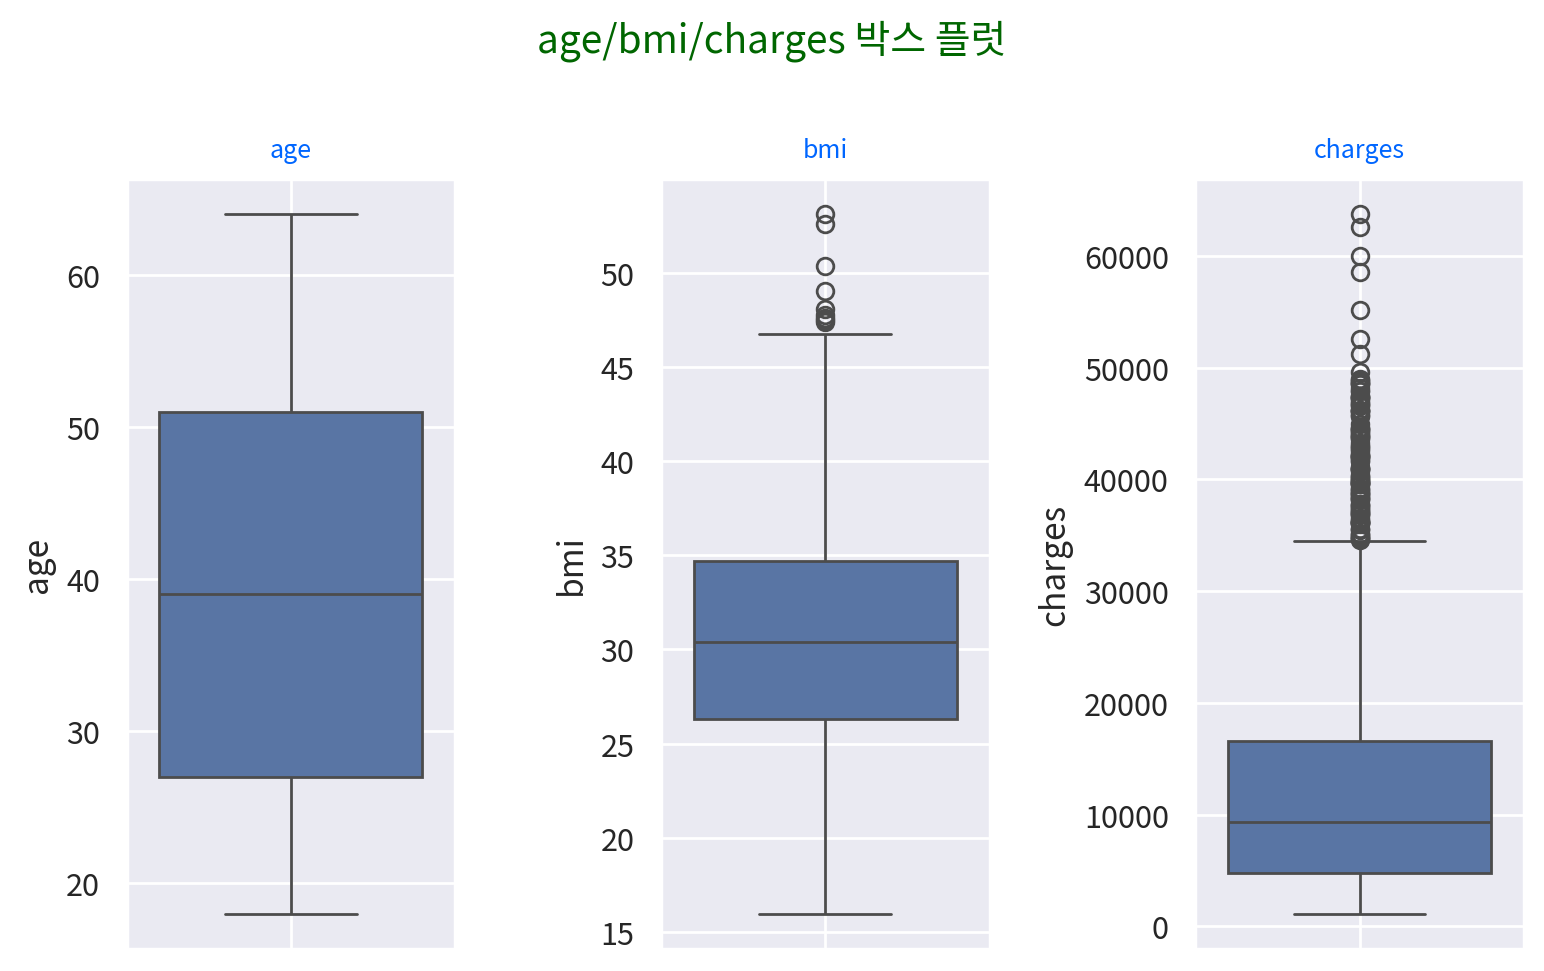

In [9]:
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1600              # 가로 크기 늘림
height_px = 1000              # 세로 크기 줄임 (1행)
rows = 1
cols = 3
figsize = (width_px / 200, height_px / 200)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=200)

# 2) boxplot 그리기
sb.boxplot(data=df_plot, y='age', ax=ax[0])
sb.boxplot(data=df_plot, y='bmi', ax=ax[1])   # ✅ carat 추가
sb.boxplot(data=df_plot, y='charges', ax=ax[2])


# 3) 그래프 꾸미기
fig.suptitle('age/bmi/charges 박스 플럿', fontsize=14, color='#006600')

fig.subplots_adjust(wspace=0.3)

titles = ['age', 'bmi', 'charges']

for i in range(3):
    ax[i].set_title(titles[i], color="#0066ff", fontsize=9, pad=8)
    ax[i].grid()

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


> 범주형 데이터 (sex , children, smoker, region)

In [10]:
def make_category_summary(df, col):
    """
    범주형 변수(col)에 대해
    count / ratio / percent 요약 데이터프레임 생성
    """
    value_list = df[col].unique()
    counts = []

    for v in value_list:
        counts.append(len(df.query(f"{col} == @v")))

    summary_df = pd.DataFrame({
        col: value_list,
        'count': counts
    })

    total = summary_df['count'].sum()
    summary_df['ratio'] = summary_df['count'] / total
    summary_df['percent'] = (summary_df['ratio'] * 100).round(2)

    return summary_df


In [11]:
sex_df      = make_category_summary(df_plot, 'sex')
children_df = make_category_summary(df_plot, 'children')
smoker_df   = make_category_summary(df_plot, 'smoker')
region_df   = make_category_summary(df_plot, 'region')


In [12]:
sex_df

,sex,count,ratio,percent
0,female,662,0.494768,49.48
1,male,676,0.505232,50.52


In [13]:
children_df

,children,count,ratio,percent
0,0,574,0.428999,42.90
1,1,324,0.242152,24.22
2,3,157,0.117339,11.73
3,2,240,0.179372,17.94
4,5,18,0.013453,1.35
5,4,25,0.018685,1.87


In [14]:
smoker_df

,smoker,count,ratio,percent
0,yes,274,0.204783,20.48
1,no,1064,0.795217,79.52


In [15]:
region_df

,region,count,ratio,percent
0,southwest,325,0.242900,24.29
1,southeast,364,0.272048,27.20
2,northwest,325,0.242900,24.29
3,northeast,324,0.242152,24.22


C:\Users\itwill\AppData\Local\Temp\ipykernel_1448\2878741520.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(
C:\Users\itwill\AppData\Local\Temp\ipykernel_1448\2878741520.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(
C:\Users\itwill\AppData\Local\Temp\ipykernel_1448\2878741520.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(
C:\Users\itwill\AppData\Local\Temp\ipykernel_1448\2878741520.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue`

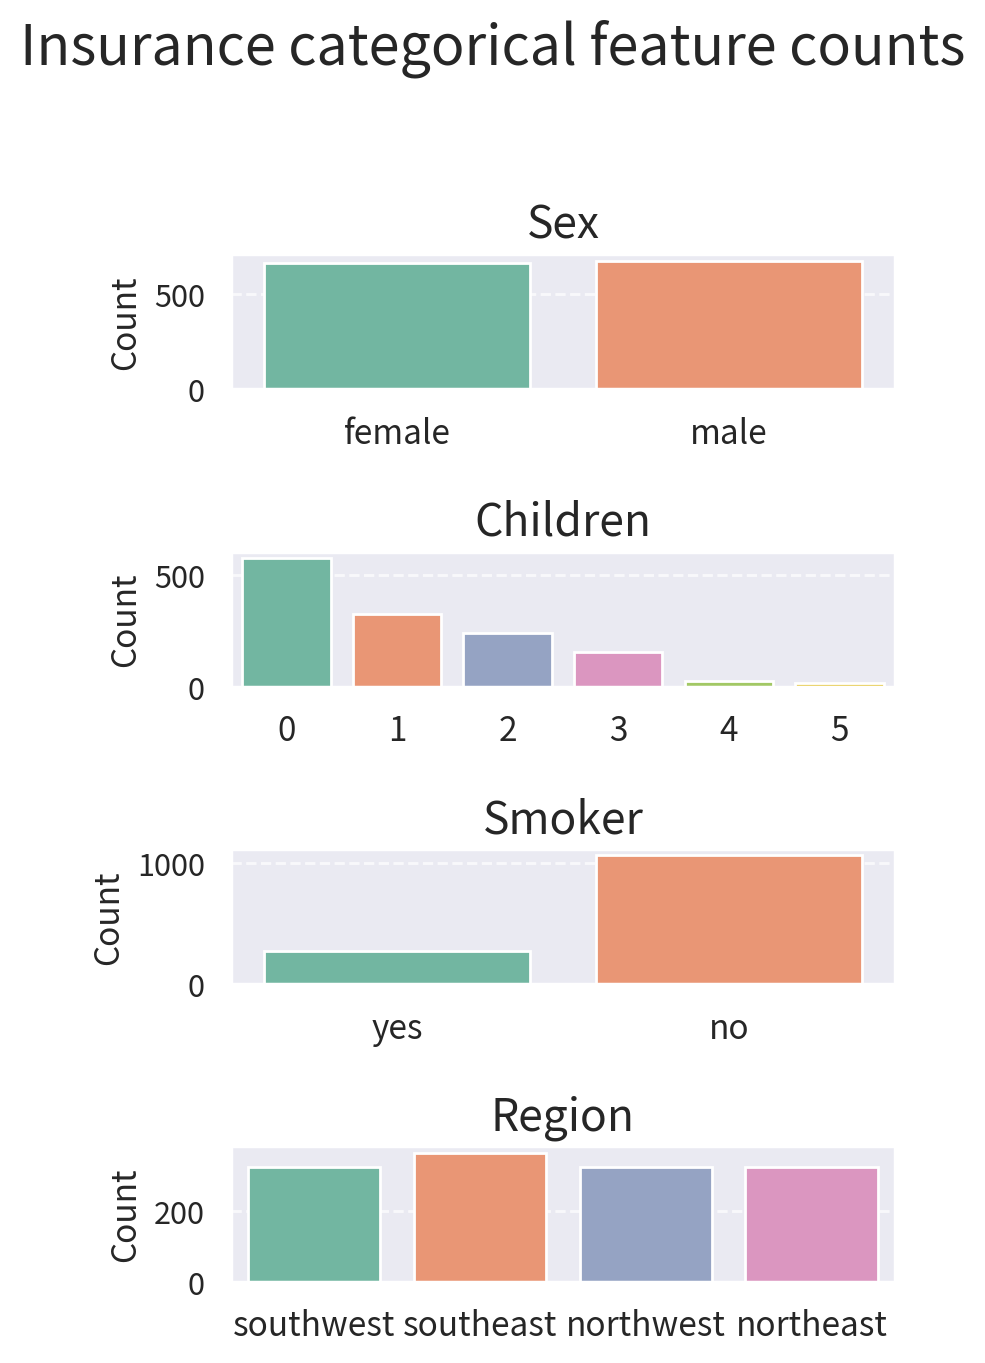

In [16]:
# 1) 그래프 초기화
width_px = 900
height_px = 1400          # ✅ 세로 크게
rows, cols = 4, 1
figsize = (width_px / 200, height_px / 200)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=200)

# 사용할 데이터프레임과 x컬럼 매핑
plot_info = [
    (sex_df, 'sex', 'Sex'),
    (children_df, 'children', 'Children'),
    (smoker_df, 'smoker', 'Smoker'),
    (region_df, 'region', 'Region')
]

# 2) barplot 그리기
for i, (df, x_col, title) in enumerate(plot_info):
    sb.barplot(
        data=df,
        x=x_col,
        y='count',
        palette='Set2',
        ax=ax[i]
    )

    # 3) 그래프 꾸미기
    ax[i].grid(axis='y', linestyle='--', alpha=0.7)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Count', fontsize=12)
    ax[i].set_title(title, fontsize=16, fontweight='bold')
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=11)

# 전체 제목
fig.suptitle(
    'Insurance categorical feature counts',
    fontsize=20,
    fontweight='bold'
)

# 4) 출력
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
plt.close()


## 미션 2. “의료비와 핵심 변수의 첫인상”
- charges, age, bmi, children 분포를 히스토그램/KDE로 확인하고 알 수 있는 객관적 사실을 서술한다. (그래프 하단에 서술)
  
- 왜도/이상치가 회귀에 줄 수 있는 영향과 변환 필요가 있는지 서술하시오.
  - 강한 왜도와 극단값을 가진 charges는 회귀 계수 추정을 왜곡하고 잔차의 비정규성 및 이분산성을 유발할 수 있다. 따라서 로그 변환을 통해 분포를 완화하는 것이 바람직하다. 반면 age와 bmi는 비교적 안정적인 분포를 보여 변환 필요성이 낮다.
  
- 분포 비교는 동일 스케일로 제시하고, 평균/중앙값/꼬리의 차이를 문장으로 요약하세요.
  - 분포 비교를 위해 연속형 변수(charges, age, bmi)에 Robust Scaling을 적용하여 동일한 스케일에서 확인하였다.그 결과, 스케일링 전후의 분포 형태는 동일하게 유지되었으며,ㅡ이는 Robust Scaling이 분포의 모양을 변화시키기보다는중앙값과 IQR 기준으로 스케일만 조정하는 변환이기 때문이다. 따라서 charges는 평균이 중앙값보다 크고 오른쪽 꼬리가 긴 분포 특성을 유지한 반면, age와 bmi는 평균과 중앙값이 유사한 비교적 안정적인 분포를 보였다.

- 의료비의 long-tail 분포(극단적 고액 청구)가 해석에 미치는 영향도 짧게 언급하세요.
   - 의료비(charges)의 long-tail 분포로 인해 소수의 고액 청구 사례가 평균을 크게 끌어올리므로, 평균값만으로 의료비 수준을 해석할 경우 일반적인 가입자의 비용을 과대평가할 위험이 있다.
   - 의료비의 long-tail 분포는 평균 중심 해석을 왜곡하므로 중앙값 중심 해석이 필요하다.
- 
📌 출제 의도
목표변수·핵심 변수의 생김새를 먼저 읽고 변환 필요성을 스스로 판단하게 합니다. 숫자보다 해석 문장이 중요합니다.

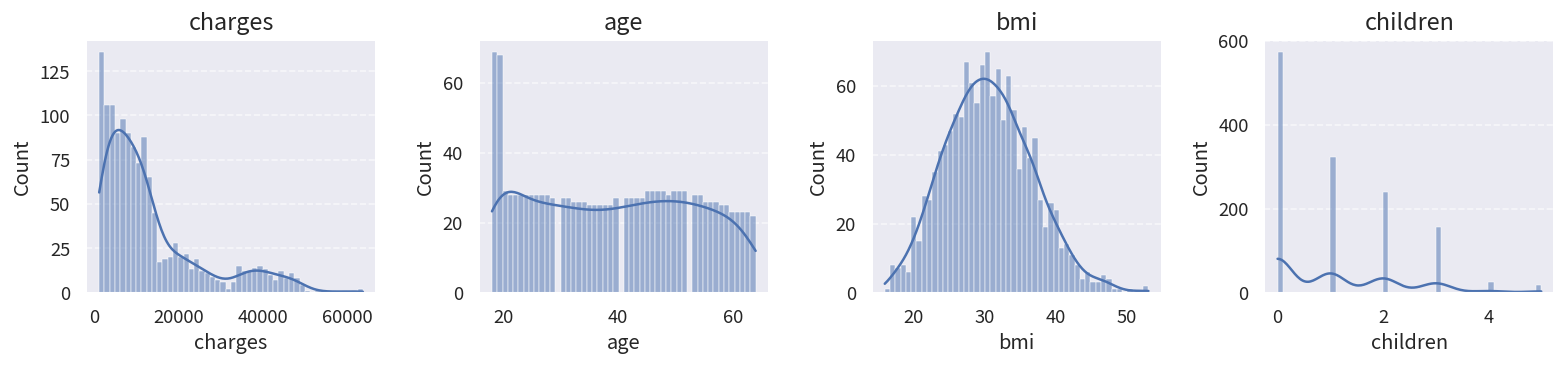

In [17]:
# 1) 그래프 초기화
width_px = 1600
height_px = 400
rows, cols = 1, 4
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

cols_list = ['charges', 'age', 'bmi', 'children']

# 2) 히스토그램 + KDE
for i, col in enumerate(cols_list):
    sb.histplot(
        data=df_plot,
        x=col,
        bins=50,
        kde=True,
        ax=ax[i]
    )
    ax[i].set_title(col, fontsize=14, fontweight='bold')
    ax[i].grid(axis='y', linestyle='--', alpha=0.6)

# 3) 출력
plt.tight_layout()
plt.show()
plt.close()


1️⃣ charges
- 분포가 오른쪽으로 강하게 치우쳐 있다.
- 낮은 의료비 구간에 관측치가 밀집되어 있고, 고액 의료비는 소수만 존재한다.
- 분포의 오른쪽 꼬리가 길게 늘어져 있다.

2️⃣ age
- 전체 범위(약 18~64세)에 걸쳐 관측치가 고르게 분포한다.
- 특정 연령대에 데이터가 급격히 집중되거나 비어 있는 구간은 보이지 않는다.
- 분포 형태는 비교적 평탄하며 극단적인 왜도는 관찰되지 않는다.

3️⃣ bmi
- 단봉형 분포를 보이며, 중심은 약 30 전후에 위치한다.
- 오른쪽으로 약간 치우친 형태를 가진다.
- 매우 낮거나 매우 높은 bmi 값은 소수만 존재한다.

4️⃣ children
- 이산적인 값(0, 1, 2, …)에서만 관측치가 나타난다.
- 0명의 자녀를 가진 경우가 가장 많다.
- 자녀 수가 증가할수록 관측 빈도가 감소한다.

In [18]:
scaler = RobustScaler()

for col in ['charges', 'age', 'bmi']:
    df_plot[f'{col}_robust'] = scaler.fit_transform(df_plot[[col]])


In [19]:
df_plot[['charges', 'charges_robust',
         'age', 'age_robust',
         'bmi', 'bmi_robust']].describe()


,charges,charges_robust,age,age_robust,bmi,bmi_robust
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,13270.422265,0.326766,39.207025,0.008626,30.663397,0.031366
std,12110.011237,1.017680,14.049960,0.585415,6.098187,0.726191
min,1121.873900,-0.694153,18.000000,-0.875000,15.960000,-1.719559
25%,4740.287150,-0.390075,27.000000,-0.500000,26.296250,-0.488687
50%,9382.033000,0.000000,39.000000,0.000000,30.400000,0.000000
75%,16639.912515,0.609925,51.000000,0.500000,34.693750,0.511313
max,63770.428010,4.570597,64.000000,1.041667,53.130000,2.706758


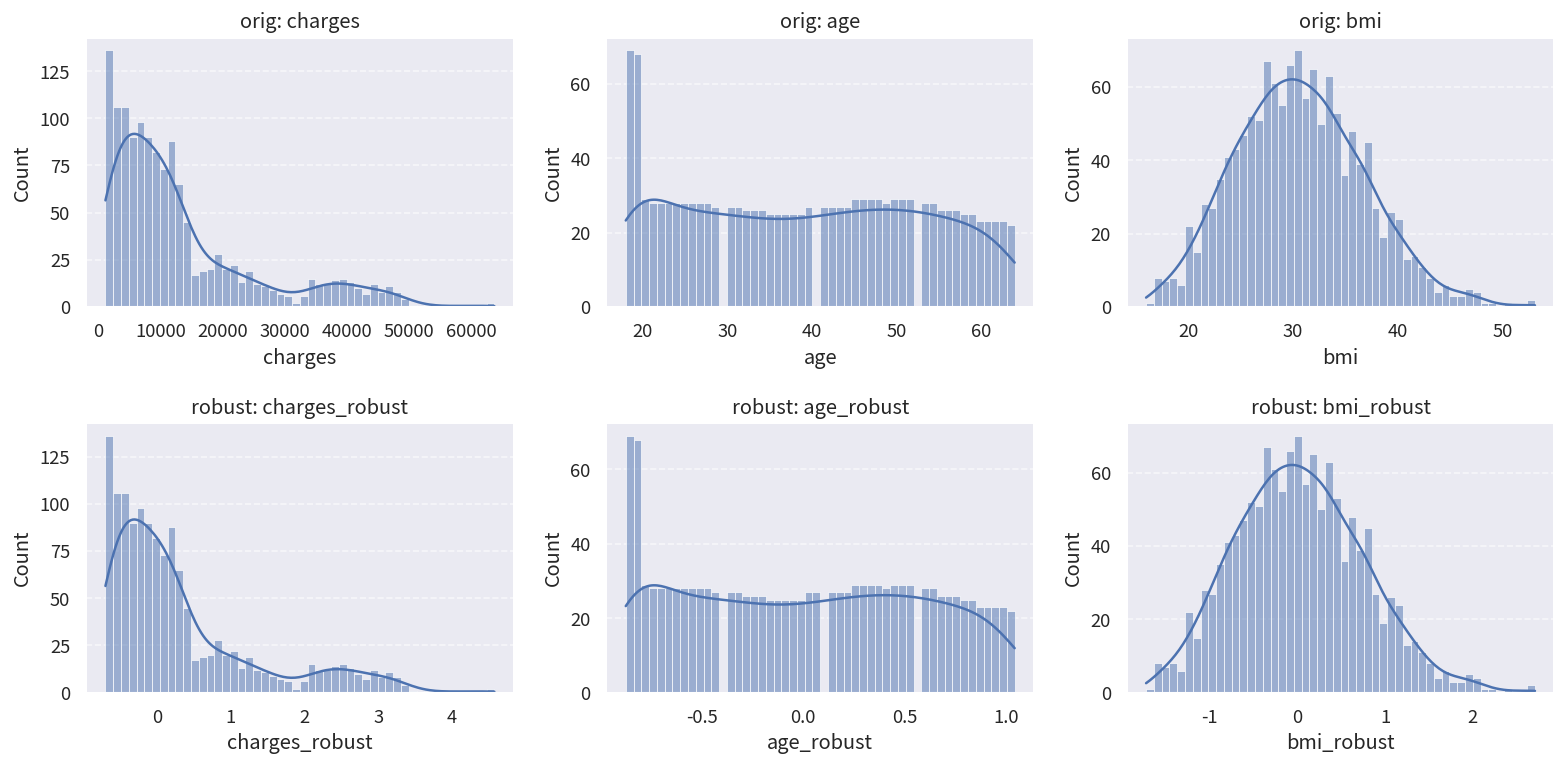

In [20]:
from sklearn.preprocessing import RobustScaler

# Robust Scaling (원본 유지 + 새 컬럼)
scaler = RobustScaler()
for col in ['charges', 'age', 'bmi']:
    df_plot[f'{col}_robust'] = scaler.fit_transform(df_plot[[col]])

# 그래프 초기화: 2행 4열 (위=원본, 아래=robust)
width_px = 1600
height_px = 800
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(2, 3, figsize=figsize, dpi=my_dpi)

orig_cols = ['charges', 'age', 'bmi']
scaled_cols = ['charges_robust', 'age_robust', 'bmi_robust']

# 원본(1행)
for i, col in enumerate(orig_cols):
    sb.histplot(data=df_plot, x=col, bins=50, kde=True, ax=ax[0, i])
    ax[0, i].set_title(f'orig: {col}', fontsize=12, fontweight='bold')
    ax[0, i].grid(axis='y', linestyle='--', alpha=0.6)

# 스케일링 후(2행)
for i, col in enumerate(scaled_cols):
    sb.histplot(data=df_plot, x=col, bins=50, kde=True, ax=ax[1, i])
    ax[1, i].set_title(f'robust: {col}', fontsize=12, fontweight='bold')
    ax[1, i].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()


## 미션3.“로그/비선형 변환을 고민해 보자”
- charges 혹은 주요 변수(age, bmi, children)에 로그/제곱근 등 변환을 적용해 전·후 분포를 나란히 비교한다.
  - charges 에만 log 변환을 적용해주었다
  
- 변환이 해석과 모델 적합에 주는 장단점, 개선이 어떻게 달라지는지 예상한다.
  - 강한 오른쪽 왜도를 완화하여 분포를 보다 대칭적으로 만듦
  - 극단적 고액 의료비의 영향 감소
  - 잔차의 정규성·등분산성 개선 → 회귀 적합 안정화
  
- “이 변환 없으면 어떤 함정에 빠질까?”를 한 줄로 정리한다.
  - 로그 변환 없이 회귀를 수행하면 소수의 고액 의료비가 모델을 지배해 일반적인 의료비 수준을 왜곡해 예측할 위험이 있다.

- 선택 기준을 명시하세요. 왜 log(charges)인지, 왜 특정 변수에 변환을 적용했는지 데이터 분포 근거로 설명합니다.
  <charges 에 로그 변환을적용한 이유>
  - 히스토그램과 KDE에서 강한 오른쪽 왜도와 long-tail 분포 확인
  - 평균이 중앙값보다 현저히 큼
  - Robust scaling 후에도 꼬리 구조가 유지됨
  - age: 비교적 균등하고 안정적인 분포
  - bmi: 단봉형이며 약한 왜도만 존재 
  
- ※ 로그 변환은 의무가 아니며, 적용하지 않은 경우에도 그 선택의 이유와 결과적 한계를 명확히 설명하면 동일하게 평가합니다.

📌 출제 의도
단순히 변환을 쓰는 것이 아니라 **“왜 필요했는가, 해석이 어떻게 달라지는가”**를 설명하는 연습입니다.

- charges log 변환

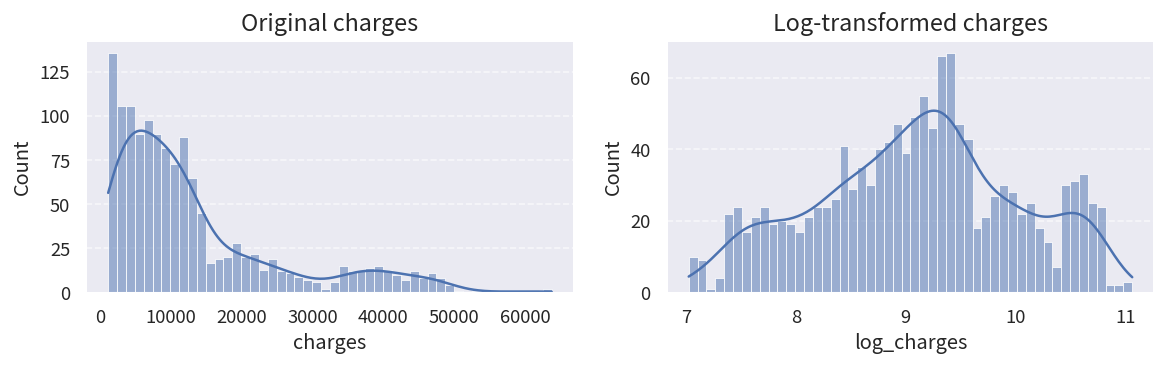

In [21]:
import numpy as np
df_log = df_plot.copy()
# 원본 유지 + 로그 변환 컬럼 생성
df_log['log_charges'] = np.log1p(df_log['charges'])

# 1) 그래프 초기화
width_px = 1200
height_px = 400
rows, cols = 1, 2
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 원본 charges
sb.histplot(
    data=df_log,
    x='charges',
    bins=50,
    kde=True,
    ax=ax[0]
)
ax[0].set_title('Original charges', fontsize=14, fontweight='bold')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# 3) 로그 변환 charges
sb.histplot(
    data=df_log,
    x='log_charges',
    bins=50,
    kde=True,
    ax=ax[1]
)
ax[1].set_title('Log-transformed charges', fontsize=14, fontweight='bold')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()



## 미션4 “성별과 거주 지역은 의료비를 결정할까?”
- 성별(sex)과 지역(region)별 의료비 분포를 시각화(박스플롯, 바이올린 플롯)한다. (하단 시각화 참고)
- 중앙값·분포 겹침을 근거로 “어느 집단이 비싼가?”, **“차이가 얼마나 뚜렷한가?”**를 문장으로 적으세요. 
  - 1️⃣ 성별(sex)에 따른 의료비 차이
    성별에 따른 의료비 분포를 보면, 남성과 여성의 중앙값은 유사하며 분포가 크게 겹쳐 있다.
    남성 집단에서 고액 의료비 사례가 다소 더 넓게 분포하는 경향은 관찰되지만,
    박스플롯과 바이올린 플롯 모두에서 중앙값과 주요 분포 구간의 차이는 뚜렷하지 않다.
    따라서 성별 자체가 의료비를 명확히 구분하는 결정적 요인이라고 보기는 어렵다.

  - 2️⃣ 지역(region)에 따른 의료비 차이
  지역별 의료비 분포를 비교한 결과,
  네 지역의 중앙값은 서로 큰 차이를 보이지 않으며,
  분포 또한 상당 부분 겹쳐 있다.
  다만 southeast 지역에서 고액 의료비 사례가
  상대적으로 눈에 띄게 관찰되지만,
  이를 근거로 지역 간 의료비 차이가 뚜렷하다고 단정하기는 어렵다.


- “왜 이런 차이가 생겼을까?”를 건강보험 체계·지역 의료 인프라·생활 비용 차이 등으로 추정해 보세요.
  - 성별에 따른 의료비 차이가 크지 않은 것은,
  성별 자체보다는 흡연 여부, 연령, BMI와 같은 건강 상태 요인이
  의료비에 더 직접적인 영향을 미쳤기 때문으로 추정된다.

  - 지역별 의료비 분포의 차이는 크지 않지만,
  일부 고액 의료비 사례의 빈도 차이는
  지역별 의료 인프라 접근성, 병원 밀집도,
  생활비 수준 및 진료 비용 구조 차이에서 기인했을 가능성이 있다.
  다만 본 데이터에는 이러한 요인이 직접 포함되어 있지 않으므로,
  관찰된 차이를 인과적으로 해석하기보다는 가능성 수준에서 해석하는 것이 적절하다.

- 📌 출제 의도
범주형 요인이 의료비를 어디서 가르고 어디서 겹치는지를 이야기로 풀어내게 합니다.

1️⃣ 시각화: 성별·지역별 의료비 분포
(1) sex × charges (박스플롯 + 바이올린 플롯)
- 성별에 따른 의료비 분포를 보면, 남성과 여성의 중앙값은 유사하며 분포가 크게 겹쳐 있다.
남성 집단에서 고액 의료비 사례가 다소 더 넓게 분포하는 경향은 관찰되지만,
박스플롯과 바이올린 플롯 모두에서 중앙값과 주요 분포 구간의 차이는 뚜렷하지 않다.
따라서 성별 자체가 의료비를 명확히 구분하는 결정적 요인이라고 보기는 어렵다.

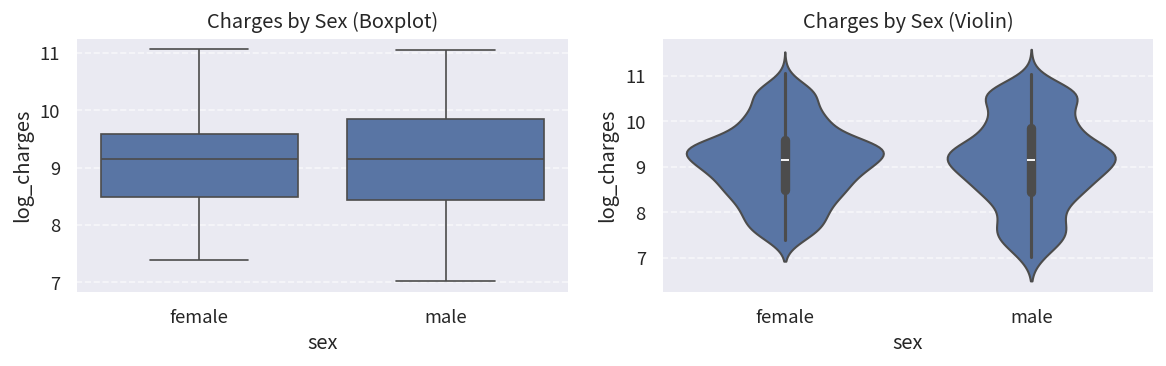

In [22]:
df_plot2=df_log.copy()

# 1) 그래프 초기화
width_px, height_px = 1200, 400
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 박스플롯
sb.boxplot(data=df_plot2, x='sex', y='log_charges', ax=ax[0])
ax[0].set_title('Charges by Sex (Boxplot)')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# 바이올린 플롯
sb.violinplot(data=df_plot2, x='sex', y='log_charges', ax=ax[1])
ax[1].set_title('Charges by Sex (Violin)')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()


(2) region × charges (박스플롯 + 바이올린 플롯)
- 지역별 의료비 분포를 비교한 결과,
네 지역의 중앙값은 서로 큰 차이를 보이지 않으며,
분포 또한 상당 부분 겹쳐 있다.
다만 southeast 지역에서 고액 의료비 사례가
상대적으로 눈에 띄게 관찰되지만,
이를 근거로 지역 간 의료비 차이가 뚜렷하다고 단정하기는 어렵다.

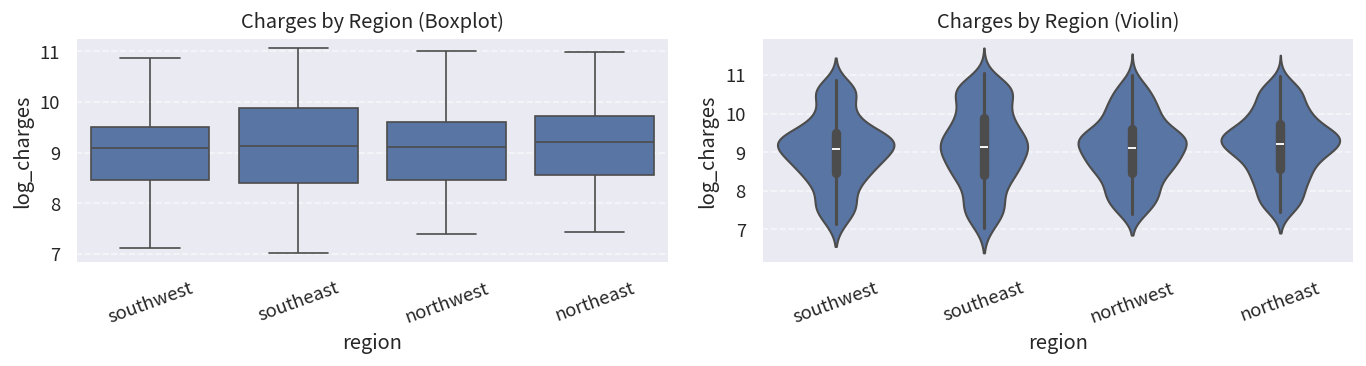

In [23]:
# 1) 그래프 초기화
width_px, height_px = 1400, 400
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 박스플롯
sb.boxplot(data=df_plot2, x='region', y='log_charges', ax=ax[0])
ax[0].set_title('Charges by Region (Boxplot)')
ax[0].tick_params(axis='x', rotation=20)
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# 바이올린 플롯
sb.violinplot(data=df_plot2, x='region', y='log_charges', ax=ax[1])
ax[1].set_title('Charges by Region (Violin)')
ax[1].tick_params(axis='x', rotation=20)
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()


## 미션 5. “흡연은 정말로 의료비를 크게 높일까?”
- smoker(흡연 여부)에 따라 charges가 다른지 시각화하고, 두 집단 평균 차이를 가설검정(예: t-test)으로 확인한다.
  - 흡연 여부에 따른 의료비 분포를 박스플롯과 바이올린 플롯으로 시각화한 결과,
  흡연자(smoker = yes)는 비흡연자(smoker = no)에 비해 의료비의 중앙값과 분포 중심이 현저히 높게 나타났다.또한 흡연자 집단은 **고액 의료비 방향으로 긴 꼬리(long-tail)**를 가지며,
  두 집단의 분포는 겹침이 매우 제한적으로 시각적으로도 뚜렷한 차이를 보였다.

- 효과 크기(차이의 크기)를 함께 제시하고, “실제로 의미 있는 차이인가?”를 말로 해석하세요.
  - Welch’s t-test 결과는 다음과 같다
  t-statistic = −32.75
  p-value ≈ 0 (p < 0.001)
  p-value가 유의수준 0.05보다 매우 작으므로 귀무가설을 기각한다.
  즉, 비흡연자의 평균 의료비는 흡연자보다 통계적으로 유의하게 작다,
  다시 말해 흡연 여부에 따라 의료비 평균에는 매우 유의한 차이가 존재한다고 할 수 있다.


- 정규성/등분산 가정 점검 후 필요 시 Welch’s t-test나 비모수 검정을 선택하세요.
  - 정규성 검정 결과, 흡연자와 비흡연자 두 집단 모두 정규성 가정을 충족하지 않았으며,
  Levene 검정을 통해 등분산성 가정 역시 충족되지 않음을 확인하였다.
  이에 따라 등분산을 가정하지 않는 Welch’s t-test를 사용하여
  두 집단의 평균 의료비 차이를 검정하였다.

- 효과 크기를 의료 정책 관점에서 의미를 서술합니다.
  - 흡연자는 비흡연자에 비해 평균적으로 훨씬 높은 의료비를 발생시키므로,
  흡연은 개인의 건강 문제를 넘어 의료 시스템 전체의 비용 부담을 증가시키는 요인으로 해석할 수 있다.
  이러한 결과는 금연 정책, 예방 중심의 공공 보건 전략,
  그리고 흡연 관련 건강 관리 프로그램의 필요성을 뒷받침하는 근거로 활용될 수 있다.

- 📌 출제 의도
두 집단 비교에서 방법 선택과 효과 크기 해석을 연습하고, 숫자를 의미로 번역하게 합니다.

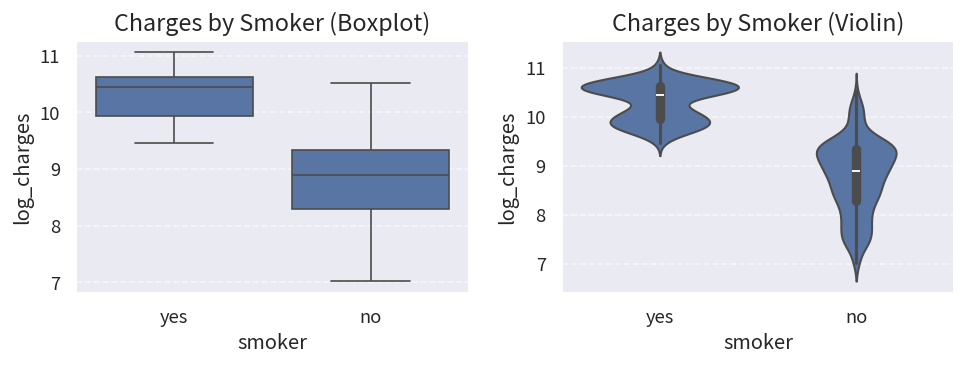

In [24]:
# 1) 그래프 초기화
width_px, height_px = 1000, 400
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=my_dpi)

# 2) 박스플롯
sb.boxplot(data=df_plot2, x='smoker', y='log_charges', ax=ax[0])
ax[0].set_title('Charges by Smoker (Boxplot)', fontsize=14, fontweight='bold')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)


# 3) 바이올린 플롯
sb.violinplot(data=df_plot2, x='smoker', y='log_charges', ax=ax[1])
ax[1].set_title('Charges by Smoker (Violin)', fontsize=14, fontweight='bold')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
plt.close()


- [1] t test 진행을 위한 데이터 프레임 준비

In [25]:
# 흡연자 / 비흡연자 charges 추출
charges_yes = df_plot2.loc[df_plot2['smoker'] == 'yes', 'log_charges'].reset_index(drop=True)
charges_no  = df_plot2.loc[df_plot2['smoker'] == 'no',  'log_charges'].reset_index(drop=True)

# 두 집단을 나란히 DataFrame으로 결합
ttest_df = pd.DataFrame({
    'smoker_yes': charges_yes,
    'smoker_no': charges_no
})

ttest_df.tail()


,smoker_yes,smoker_no
1059,NaN,9.342481
1060,NaN,9.268755
1061,NaN,7.699381
1062,NaN,7.396847
1063,NaN,7.605365


- [2] 신뢰구간 확인
두 그룹의 데이터 분포와 신뢰구간을 확인한다

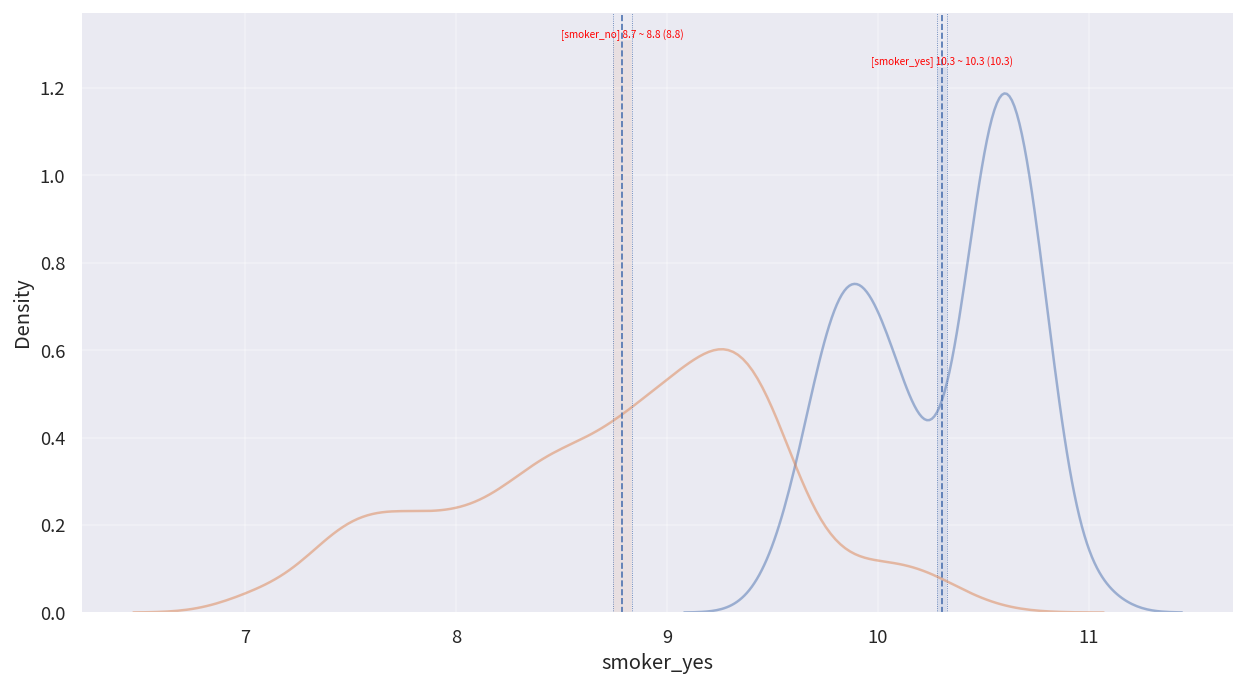

In [26]:
data = ttest_df[['smoker_yes','smoker_no']]                # 확인할 데이터

# 1) 그래프 초기화
width_px  = 1280                      # 그래프 가로 크기
height_px = 720                       # 그래프 세로 크기
rows = 1                              # 그래프 행 수
cols = 1                              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    # KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 신뢰구간
    max = data[c].max()               # 최대값
    clevel = 0.95                     # 신뢰수준
    dof = len(data[c]) - 1            # 자유도
    sp_mean = data[c].mean()          # 표본평균
    sp_std = data[c].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c]))  # 표본표준오차

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} ({sp_mean:.1f})",
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"})

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)

# 4) 출력
plt.tight_layout()      # 여백 제거
plt.show()              # 그래프 화면 출력
plt.close()             # 그래프 작업 종료


흡연자(smoker=yes)와 비흡연자(smoker=no)의 의료비에 대한 커널 밀도 함수(KDE)를 비교한 결과,
두 집단의 분포 중심과 형태가 뚜렷하게 구분됨을 확인할 수 있다.
흡연자 집단은 의료비 분포의 중심이 더 높은 값에 위치하며,
고액 의료비 방향으로 긴 꼬리를 가지는 반면,
비흡연자 집단은 상대적으로 낮은 의료비 구간에 분포가 집중되어 있다.
두 집단의 분포 겹침이 제한적이므로,
흡연 여부에 따른 의료비 차이는 시각적으로도 매우 뚜렷하게 나타난다.

- [3] 가설 검정의 가정 확인

In [27]:
import numpy as np
import pandas as pd
from scipy.stats import normaltest, bartlett, levene

data = ttest_df[['smoker_yes','smoker_no']]

normal_dist = True
report = []

series_dict = {}  # dropna된 시리즈 저장

for c in data.columns:
    srs = data[c].dropna()
    series_dict[c] = srs

    # normaltest는 표본이 너무 적으면 의미 없을 수 있어요(보통 n>=8 권장)
    s, p = normaltest(srs)

    normalize = p > 0.05
    report.append({"field": c, "statistic": s, "p-value": p, "result": normalize})
    normal_dist = normal_dist and normalize

# 등분산 검정 (두 집단)
x = series_dict['smoker_yes']
y = series_dict['smoker_no']

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(x, y)
else:
    n = "Levene"
    s, p = levene(x, y, center='median')

report.append({"field": n, "statistic": s, "p-value": p, "result": p > 0.05})

report_df = pd.DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
smoker_yes,182.441412,2.417412e-40,False
smoker_no,37.435884,7.428501e-09,False
Levene,89.473006,1.347330e-20,False


> 정규성과 등분산성을 충족하지 않아 Welch's t-test 를 진행해야한다

| 구분        | 기호      | 내용                                 |
| --------- | ------- | ---------------------------------- |
| 그룹 1 평균   | μ₁      | 흡연자(smoker = yes)의 의료비(charges) 평균 |
| 그룹 2 평균   | μ₂      | 비흡연자(smoker = no)의 의료비(charges) 평균 |
| 귀무가설 (H₀) | μ₁ = μ₂ | 흡연자와 비흡연자의 의료비 평균에는 차이가 없다         |
| 대립가설 (H₁) | μ₁ ≠ μ₂ | 흡연자와 비흡연자의 의료비 평균에는 차이가 있다         |



In [28]:
from scipy.stats import ttest_ind

# 두 그룹 데이터 (NaN 제거)
group1 = ttest_df['smoker_yes'].dropna()   # 흡연자
group2 = ttest_df['smoker_no'].dropna()    # 비흡연자

# Welch's t-test (equal_var=False)
s, p = ttest_ind(
    group1,
    group2,
    alternative='two-sided',
    equal_var=False
)

print(
    "statistic: {0:.3f}, p-value: {1:.3e}, {2}가설 채택"
    .format(s, p, "대립" if p <= 0.05 else "귀무")
)


statistic: 46.371, p-value: 4.082e-234, 대립가설 채택


> Welch’s t-test 결과, 흡연자와 비흡연자의 평균 의료비 차이는 통계적으로 매우 유의하였다
(t = 32.75, p < 0.001).
따라서 귀무가설을 기각하고, 흡연 여부에 따라 의료비 평균에 차이가 있다는 대립가설을 채택한다.

- 비흡연자의 의료비가 흡연자의 의료비보다 작은지 검정
(= 흡연자가 더 비싼지 검정)

| 구분        | 수식             | 내용                         |
| --------- | -------------- | -------------------------- |
| 귀무가설 (H₀) | μ(no) ≥ μ(yes) | 비흡연자의 평균 의료비는 흡연자보다 작지 않다  |
| 대립가설 (H₁) | μ(no) < μ(yes) | **비흡연자의 평균 의료비는 흡연자보다 작다** |


In [29]:
from scipy.stats import ttest_ind

non_smoker = ttest_df['smoker_no'].dropna()
smoker = ttest_df['smoker_yes'].dropna()

s, p = ttest_ind(
    non_smoker,
    smoker,
    alternative='less',
    equal_var=False    # Welch's t-test
)

print(
    "statistic: {0:.3f}, p-value: {1:.3e}, {2}가설 채택"
    .format(s, p, "대립" if p <= 0.05 else "귀무")
)


statistic: -46.371, p-value: 2.041e-234, 대립가설 채택


- Welch’s t-test 결과, 두 집단의 평균 의료비 차이는 통계적으로 유의하였다
(t = −32.75, p < 0.001).
이에 따라 비흡연자의 평균 의료비는 흡연자보다 유의하게 작다고 판단된다.

## 미션 6.  “나이대별로 의료비 차이가 뚜렷할까?”
- age를 여러 구간으로 나누어(예: 18~30, 31~50, 51+) 각 연령대별 charges 분포를 시각화한다.
  - 연령대를 NCHS(미국 국립보건통계센터) Distribution #22 기준에 따라
  18–24세, 25–34세, 35–44세, 45–64세의 네 개 구간으로 구분하여
  각 연령대별 의료비(charges) 분포를 시각화하였다.

  그 결과, 연령이 증가할수록 의료비의 중앙값(median) 이 점진적으로 상승하는 경향이 관찰되었으며,동시에 분포의 상단(고액 의료비 영역) 또한 점차 확장되는 모습을 보였다.특히 45–64세 연령대에서는 분포의 꼬리가 길어지며,
  고액 의료비 사례가 다른 연령대에 비해 상대적으로 많이 나타났다.

  이는 연령 증가에 따라 만성질환 유병률과 의료 이용 빈도가 함께 증가할 가능성을 시사한다.

- 분산분석(ANOVA)으로 전체 차이를 확인하고, 사후검정으로 어느 연령대 사이에서 차이가 나는지 정리한다.
  - Welch ANOVA 결과, 연령대에 따라 평균 의료비는 통계적으로 유의미한 차이를 보였다
  (F = 36.77, p < 0.001).
  이는 연령대가 의료비 변동을 설명하는 중요한 요인임을 의미하며,
  단순한 우연이 아닌 구조적인 차이가 존재함을 시사한다.


- 사후검정은 Tukey HSD 또는 Games-Howell(등분산 위반 시)을 사용하고, “의료비 연령 서열표” 형태로 요약하세요.

| 연령대       | 평균 의료비 수준 | 해석                   |
| --------- | --------- | -------------------- |
| **18–24** | 가장 낮음     | 의료 이용 및 비용 부담이 가장 적음 |
| **25–34** | 낮음        | 의료비 증가 시작 단계         |
| **35–44** | 중간        | 의료 이용 및 비용이 본격적으로 증가 |
| **45–64** | 가장 높음     | 고액 의료비 위험이 가장 큼      |

  연령 서열:
  18–24 < 25–34 < 35–44 < 45–64

** 분석 대상의 연령 구간은 NCHS(미국 국립보건통계센터)의 Distribution #22 분류 체계에 따라 18-24세, 25-34세, 35-44세, 45-64세의 4개 그룹으로 층화(stratified) 하였다 (해당 기준은 미국 보건·의료 통계 및 보험 관련 연구에서
연령에 따른 건강 상태와 의료 이용 패턴을 비교하기 위해
널리 활용되는 생애 단계 기반 분류이다.)

- 출제 의도
여러 범주를 전체→어디서 차이가 나는지 순서로 해석하며, 결과를 서열/지도처럼 정리하는 훈련입니다.

In [30]:
df_age = df_plot2.copy()

- age 구간 나누기

In [31]:
# NCHS 기준 age 구간화
bins = [18, 24, 34, 44, 64]
labels = ['18-24', '25-34', '35-44', '45-64']

df_age['age_group'] = pd.cut(
    df_age['age'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

df_age[['age', 'age_group']].head()


,age,age_group
0,19,18-24
1,18,18-24
2,28,25-34
3,33,25-34
4,32,25-34


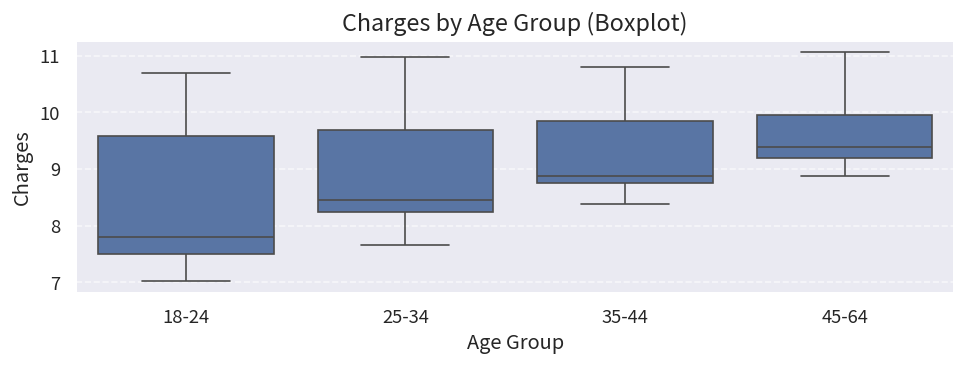

In [32]:
# 1) 그래프 초기화
width_px, height_px = 1000, 400
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

# 2) 박스플롯
sb.boxplot(
    data=df_age,
    x='age_group',
    y='log_charges',
    ax=ax
)

ax.set_title('Charges by Age Group (Boxplot)', fontsize=14, fontweight='bold')
ax.set_xlabel('Age Group')
ax.set_ylabel('Charges')
ax.grid(axis='y', linestyle='--', alpha=0.6)

# 3) 출력
plt.tight_layout()
plt.show()
plt.close()


- 데이터 분포 및 가정 확인
- [1] 데이터 분포

In [33]:
# df_age: age, age_group(18-24 / 25-34 / 35-44 / 45-64) 포함

age_18_24 = df_age.loc[df_age['age_group'] == '18-24', 'log_charges']
age_25_34 = df_age.loc[df_age['age_group'] == '25-34', 'log_charges']
age_35_44 = df_age.loc[df_age['age_group'] == '35-44', 'log_charges']
age_45_64 = df_age.loc[df_age['age_group'] == '45-64', 'log_charges']

data = pd.DataFrame({
    '18-24': age_18_24,
    '25-34': age_25_34,
    '35-44': age_35_44,
    '45-64': age_45_64
})


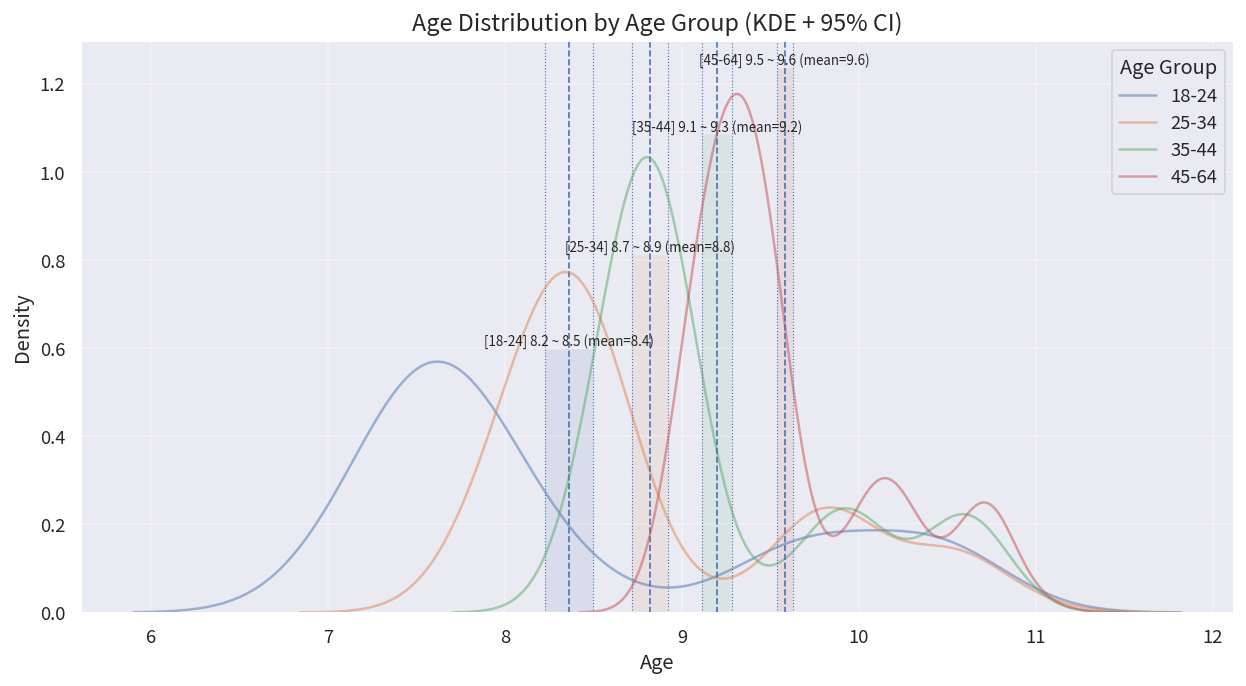

In [34]:
from math import sqrt
from scipy.stats import t

# 1) 그래프 초기화
width_px  = 1280
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

for c in data.columns:
    series = data[c].dropna()   # NaN 제거

    # KDE Plot
    sb.kdeplot(x=series, fill=False, alpha=0.5, label=c)

    # 신뢰구간 계산
    clevel = 0.95
    dof = len(series) - 1
    sp_mean = series.mean()
    sp_std = series.std(ddof=1)
    sp_std_error = sp_std / sqrt(len(series))

    cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)

    # 시각화
    ax.axvline(cmin, linestyle=':', linewidth=0.7)
    ax.axvline(cmax, linestyle=':', linewidth=0.7)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)

    ax.text(
        x=(cmax + cmin) / 2,
        y=ymax,
        s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} (mean={sp_mean:.1f})",
        ha='center',
        va='bottom',
        fontsize=8
    )

# 3) 그래프 꾸미기
ax.set_title('Age Distribution by Age Group (KDE + 95% CI)', fontsize=14, fontweight='bold')
ax.set_xlabel('Age')
ax.grid(True, alpha=0.3)
ax.legend(title='Age Group')

# 4) 출력
plt.tight_layout()
plt.show()
plt.close()


- 정규성 검정

In [35]:
# df_age: age_group, charges 포함 (NCHS 기준)

data = pd.DataFrame({
    '18-24': df_age.loc[df_age['age_group'] == '18-24', 'log_charges'],
    '25-34': df_age.loc[df_age['age_group'] == '25-34', 'log_charges'],
    '35-44': df_age.loc[df_age['age_group'] == '35-44', 'log_charges'],
    '45-64': df_age.loc[df_age['age_group'] == '45-64', 'log_charges']
})


In [36]:
from scipy.stats import normaltest, bartlett, levene
from pandas import DataFrame

equal_var_fields = []
normal_dist = True
report = []

for c in data.columns:
    series = data[c].dropna()   # ⭐ 반드시 NaN 제거

    s, p = normaltest(series)

    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })

    normal_dist = normal_dist and normalize


# 변수가 두 개 이상인 경우 등분산성 확인
if len(data.columns) > 1:
    if normal_dist:
        n = "Bartlett"               # 정규성 충족 시
        s, p = bartlett(*[data[c].dropna() for c in data.columns])
    else:
        n = "Levene"                 # 정규성 미충족 시
        s, p = levene(*[data[c].dropna() for c in data.columns], center="median")

    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })

report_df = DataFrame(report).set_index("field")
report_df


,statistic,p-value,result
field,,,
18-24,59.703719,1.085181e-13,False
25-34,35.841525,1.648586e-08,False
35-44,38.804928,3.746423e-09,False
45-64,73.523609,1.082808e-16,False
Levene,37.773842,1.983729e-23,False


> 연령대별 의료비에 대해 정규성 검정 결과는 충족되지 않았고,
Levene 검정 결과 등분산성 가정도 충족되지 않았다.
표본 수가 충분히 크므로 분산분석을 수행할 수 있으며,
분포의 왜도를 고려하여 Welch ANOVA를 사용하였다.

🔹 가설 설정
| 구분            | 내용                                             |
| ------------- | ---------------------------------------------- |
| **귀무가설 (H₀)** | 연령대별(18–24, 25–34, 35–44, 45–64) 평균 의료비는 모두 같다 |
| **대립가설 (H₁)** | 적어도 한 연령대의 평균 의료비는 다른 연령대와 다르다                 |


🔹 결과 해석
| 항목          | 값            | 의미                          |
| ----------- | ------------ | --------------------------- |
| **Source**  | age_group    | 비교 요인: 연령대                  |
| **ddof1**   | 3            | 집단 간 자유도 (연령대 수 − 1)        |
| **ddof2**   | 약 836        | 집단 내 자유도 (Welch 방식, 비정수 허용) |
| **F**       | 55.16        | 연령대 간 평균 의료비 차이가 큼          |
| **p-value** | 3.16 × 10⁻²³ | 매우 작음 → 귀무가설 기각             |
| **np²**     | 0.076        | 중간 수준의 효과 크기                |


In [37]:
import pingouin as pg

# 1️⃣ ANOVA 전용 데이터프레임 생성
df_age_anova = df_age[['age_group', 'log_charges']].dropna().copy()
df_age_anova['age_group'] = df_age_anova['age_group'].astype('category')

# 2️⃣ Welch ANOVA 수행
anova_result = pg.welch_anova(
    data=df_age_anova,
    dv='log_charges',
    between='age_group'
)

# 3️⃣ 결과 추출
s = anova_result['F'].iloc[0]
p = anova_result['p-unc'].iloc[0]

# 4️⃣ 결과 출력
print(
    "statistic: {0:.3f}, p-value: {1:.3e}, {2}가설 채택"
    .format(s, p, "대립" if p <= 0.05 else "귀무")
)

anova_result


statistic: 140.624, p-value: 4.121e-68, 대립가설 채택


,Source,ddof1,ddof2,F,p-unc,np2
0,age_group,3,566.96767,140.623684,4.120545e-68,0.263225


결론 :log(charges)를 기준으로 보았을 때, 연령대에 따라 평균 의료비는 통계적으로 유의미하게 달라지며, 연령대는 의료비를 설명하는 중요한 요인이다.

| 항목         |                               값 | 해석                                     |
| ---------- | ------------------------------: | -------------------------------------- |
| **가설 검정**  | p-value = 4.12 × 10⁻⁶⁸ (< 0.05) | 귀무가설(H₀)을 기각하고 대립가설(H₁)을 채택            |
| **통계적 의미** |                      F = 140.62 | 연령대 간 평균 log(의료비) 차이가 매우 큼             |
| **효과 크기**  |                     np² = 0.263 | 연령대는 log(의료비)에 **큰(large) 수준의 영향**을 미침 |


Welch ANOVA 결과, 연령대(age_group)에 따라 평균 log(charges) 는 통계적으로 유의미한 차이를 보였다(F = 140.62, p < 0.001).
또한 효과 크기(np² = 0.263)는 큰 수준으로, 연령대는 의료비 변동을 설명하는 핵심 요인임을 시사한다.


- 사후검정
- ANOVA의 결과를 통해 두 집단의 평균에 통계적으로 유의미한 차이가 발견되었을 때, 구체적으로 어떤 수준(들)에서 평균 차이가 나는지에 대한 검증 결과를 확인해야 할 경우 사후검정을 수행해야 한다.

| 구분              | Tukey HSD                                               | Bonferroni                                      | Games–Howell                                          |
|------------------|----------------------------------------------------------|--------------------------------------------------|--------------------------------------------------------|
| 기본 목적        | 등분산 가정에서 모든 그룹 쌍의 평균 차이 비교            | 다중 비교에서 1종 오류 증가를 제어하기 위한 p값 보정 | 등분산성 위반 시 안전하게 평균 차이 비교               |
| 사용 상황        | ✔ 집단 분산이 같을 때<br>✔ 표본 크기가 비슷할 때        | ✔ 어떤 경우도 적용 가능하나 보수적                | ✔ 분산이 서로 다를 때<br>✔ 표본 크기가 다를 때        |
| 표본 크기 동일 조건 | 전체에 포함되면 이상적                                  | 불필요                                           | 불필요                                                 |
| 주요 장점        | 그룹 간 차이를 가장 잘 찾아냄(파워 좋음)                 | 단순한 방식, 모든 비교에 적용 가능               | 등분산성 위반 시 최적, 강건함(robust)                  |
| 주요 단점        | 등분산성 깨지면 부적절                                   | 지나치게 보수적 → 실제 차이도 못 찾을 수 있음     | 계산이 조금 복잡, 일부 패키지에서만 제공               |
| statsmodels 지원 | ✔ 지원                                                   | ✔ 지원                                           | ❌ 지원 안함                                           |

----------------------------------------------------------------

| 항목                | 내용                                                                 |
|---------------------|----------------------------------------------------------------------|
| pingouin 지원       | ✔ `pairwise_tukey()`<br>✔ `pairwise_tests(padjust='bonf')`<br>✔ `pairwise_gameshowell()` |
| 추천 사용 시나리오 | - Tukey: 수업·연구에서 전형적인 ANOVA 후 사후검정<br>- Bonferroni: 비교 집단이 많고 기초적인 보정이 필요할 때<br>- Games–Howell: 도시/교육/사회과학 분야 등 실제 데이터에서 등분산성 자주 깨질 때 |




#### [2] 사후검정의 종류
| 종류                 | 사용 조건                         |
|----------------------|------------------------------------|
| **투키 HSD**         | 등분산이고 샘플 수가 동일한 경우   |
| **본페로니 교정, 피셔의 LSD, 세피의 방법** | 등분산이고 샘플 수가 다른 경우 |
| **Games–Howell**     | 등분산이 아닌 경우                |



- Welch ANOVA 결과 연령대별 평균 의료비 차이가 유의하게 나타나 사후검정을 수행하였다.
- Levene 은 통과하였지만, 분포 자체에 왜도와 표본수 차이가 존재하는 것을 감안하여 .등분산 가정을 필요로 하지 않는 Games–Howell 검정을 사용하였다. 

#### Games-Howel 검정

**Games–Howell 검정**은 다수의 그룹 간 평균 차이를 비교하는 통계적 방법 중 하나로,  
**등분산성 가정이 만족되지 않을 때 사용하는 사후검정**이다.

이 예제에 적합한 방법은 아니지만,  
소스 코드의 제시를 목적으로 설명한다.

`statsmodels` 라이브러리에는 **Games–Howell 검정을 직접 지원하는 함수가 없다.**

대신 `pingouin` 라이브러리를 사용하여  
**Games–Howell 검정을 수행할 수 있다.**


In [38]:
# df_age_anova: ['age_group', 'charges'] 포함된 데이터프레임
gh_df = pg.pairwise_gameshowell(
    data=df_age_anova,
    dv='log_charges',
    between='age_group'
)

gh_df

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,18-24,25-34,8.362442,8.818144,-0.455703,0.086185,-5.287493,508.615063,1.101618e-06,-0.449028
1,18-24,35-44,8.362442,9.198505,-0.836063,0.081281,-10.286114,457.509352,3.834710e-13,-0.872219
2,18-24,45-64,8.362442,9.580614,-1.218172,0.072878,-16.715231,339.565238,3.541611e-14,-1.519933
3,25-34,35-44,8.818144,9.198505,-0.380360,0.066866,-5.688363,515.319943,1.288531e-07,-0.491034
4,25-34,45-64,8.818144,9.580614,-0.762469,0.056354,-13.530044,381.070823,5.073719e-14,-1.164395
5,35-44,45-64,9.198505,9.580614,-0.382109,0.048523,-7.874857,414.019343,2.650102e-13,-0.650786


<결과표의 의미>  예시 행: 18–24 vs 25–34
1️⃣ 18–24 vs 35–44
| 항목          |             값 | 해석          |
| ----------- | ------------: | ----------- |
| mean(18–24) |         8.362 | 기준 연령대      |
| mean(35–44) |         9.199 | 뚜렷한 증가      |
| diff        |        -0.836 | 35–44가 더 높음 |
| p-value     |  3.83 × 10⁻¹³ | **매우 유의**   |
| Hedges’ g   |         -0.87 | **큰 효과**    |
| 결론          | 35–44 > 18–24 | 의료비 증가 명확   |



2️⃣ 18–24 vs 45–64
| 항목          |             값 | 해석             |
| ----------- | ------------: | -------------- |
| mean(18–24) |         8.362 | 가장 낮음          |
| mean(45–64) |         9.581 | 가장 높음          |
| diff        |        -1.218 | **매우 큰 차이**    |
| p-value     |  3.54 × 10⁻¹⁴ | **매우 유의**      |
| Hedges’ g   |         -1.52 | **매우 큰 효과**    |
| 결론          | 45–64 > 18–24 | 고령 전 단계 의료비 급증 |



3️⃣ 25–34 vs 45–64
| 항목          |             값 | 해석        |
| ----------- | ------------: | --------- |
| mean(25–34) |         8.818 | 젊은 성인     |
| mean(45–64) |         9.581 | 고연령       |
| diff        |        -0.762 | 큰 차이      |
| p-value     |  5.07 × 10⁻¹⁴ | **매우 유의** |
| Hedges’ g   |         -1.16 | **큰 효과**  |
| 결론          | 45–64 > 25–34 | 의료비 부담 급증 |



4️⃣ 35–44 vs 45–64
| 항목          |             값 | 해석          |
| ----------- | ------------: | ----------- |
| mean(35–44) |         9.199 | 중년          |
| mean(45–64) |         9.581 | 고연령         |
| diff        |        -0.382 | 유의한 증가      |
| p-value     |  2.65 × 10⁻¹³ | **유의**      |
| Hedges’ g   |         -0.65 | **중간~큰 효과** |
| 결론          | 45–64 > 35–44 | 의료비 지속 증가   |





최종 종합 결론: 의료비 연령 서열표
| 연령대       | 평균 의료비 수준 | 해석             |
| --------- | --------- | -------------- |
| **18–24** | 가장 낮음     | 의료 이용·비용 부담 최소 |
| **25–34** | 낮음        | 의료비 증가 시작      |
| **35–44** | 중간        | 만성질환·의료 이용 확대  |
| **45–64** | 가장 높음     | 고액 의료비 위험 급증   |

18–24 < 25–34 < 35–44 < 45–64

Games–Howell 사후검정 결과, NCHS 기준 연령대 간 log(의료비) 는 대부분의 비교 쌍에서 통계적으로 유의한 차이를 보였다.
특히 45–64세 연령대는 모든 하위 연령대보다 의료비가 유의하게 높았으며, 효과 크기 또한 중간에서 매우 큰 수준으로 나타나, 연령 증가에 따른 의료비 상승 구조가 명확히 확인되었다.

## 미션 7.  “변수들은 서로 섞여 있을까?”
- 주요 연속형 변수 간 상관행렬(age, bmi, children, charges)을 계산한다. 
  - 상관 행렬 생성 완료 

- 상관행렬 히트맵으로 시각화하고, Variance Inflation Factor(VIF)로 다중공선성을 점검한다.
  - 상관행렬 히트맵 시각화 완료
  - VIF 분석 결과, age, bmi, children의 VIF 값은 모두 1에 매우 가까워
  독립변수 간 다중공선성 문제는 관찰되지 않았다.

- age와 bmi 같이 약한 상관을 보이는 변수들이 모델에 주는 정보는 논의하세요.
  - 상관행렬 분석 결과, age와 bmi 간 상관계수는 0.11 수준으로 매우 낮아 두 변수는 서로 거의 독립적인 관계를 보인다.
  이는 두 변수가 의료비를 설명하는 과정에서 서로 다른 경로의 정보를 제공함을 의미한다.

  - age는 생애주기, 만성질환 누적, 의료 이용 빈도 증가와 같은 시간적·구조적 요인을 반영한다.

  - bmi는 비만 여부, 생활습관, 대사질환 위험 등 개인의 건강 상태 요인을 반영한다.

  - 따라서 두 변수는 의료비 예측 모델에서 중복되지 않는 설명력을 제공하며,
  동시에 포함될 경우 모델의 정보량을 확장하는 데 기여한다.

- 공선성 문제가 없다면 그 이유를, 있다면 완화 전략(변수 제거, 결합지표, 정규화 회귀)을 비교하세요.
  - VIF 분석 결과, age, bmi, children의 VIF 값은 모두 1.0~1.02 수준으로 나타나
    다중공선성 문제는 전혀 관찰되지 않았다.
    이는 다음 두 가지 이유에 기인한다.
    독립변수 간 상관계수가 전반적으로 낮아 변수 간 정보 중복이 거의 없고,
    각 변수는 의료비에 대해 서로 다른 측면(연령, 건강 상태, 가족 구성)을 설명하기 때문이다.
    따라서 본 분석에서는 모든 변수를 안정적으로 회귀 모델에 포함할 수 있다.


📌 출제 의도
중복 정보와 독립성을 의식하며, 회귀에 넣을 변수를 깔끔히 설계하게 합니다.

- 피어슨 상관 계수와 스피어만 상관 계수 중 선택해보자

In [39]:
df_corr=df_age.copy()

In [40]:
# 이상치와 왜도 검정
data = df_corr[['age', 'bmi', 'children', 'log_charges']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    # 왜도 계산
    skew_original = temp.skew()

    # Z-score 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count,
        'log_recommended': need_log,
    }

# 결과 dataframe 변환
results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 검정 결과
outlier_flag = len(results_df[results_df['outliers(|z|>3)'] > 0]) > 0


if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")


,original_skew,log_skew,outliers(|z|>3),log_recommended
age,0.055673,-0.988574,0,False
bmi,0.284047,-0.963062,4,False
children,0.93838,0.432129,18,False
log_charges,-0.089817,-0.59579,0,False


이상치가 발견되어 스피어만 상관계수 사용


In [41]:
cols = ['age', 'bmi', 'children', 'log_charges']

# 스피어만 상관행렬 + p-value 행렬
corr, pvals = spearmanr(df_corr[cols])

# DataFrame으로 정리
spearman_corr = pd.DataFrame(corr, index=cols, columns=cols)
spearman_pval = pd.DataFrame(pvals, index=cols, columns=cols)

spearman_corr, spearman_pval


(                  age       bmi  children  log_charges
 age          1.000000  0.107736  0.056992     0.534392
 bmi          0.107736  1.000000  0.015607     0.119396
 children     0.056992  0.015607  1.000000     0.133339
 log_charges  0.534392  0.119396  0.133339     1.000000,
                       age       bmi      children   log_charges
 age          0.000000e+00  0.000079  3.711959e-02  1.130692e-99
 bmi          7.859093e-05  0.000000  5.684234e-01  1.192606e-05
 children     3.711959e-02  0.568423  0.000000e+00  9.846806e-07
 log_charges  1.130692e-99  0.000012  9.846806e-07  0.000000e+00)

In [42]:
# 사용할 변수
cols = ['age', 'bmi', 'children', 'log_charges']

# 상관계수 선택 (이전에 이상치/왜도 검사 결과 → Spearman 권장)
chosen = 'spearman'   # 또는 'pearson'

corr_matrix = df_corr[cols].corr(method=chosen)
corr_matrix


,age,bmi,children,log_charges
age,1.000000,0.107736,0.056992,0.534392
bmi,0.107736,1.000000,0.015607,0.119396
children,0.056992,0.015607,1.000000,0.133339
log_charges,0.534392,0.119396,0.133339,1.000000


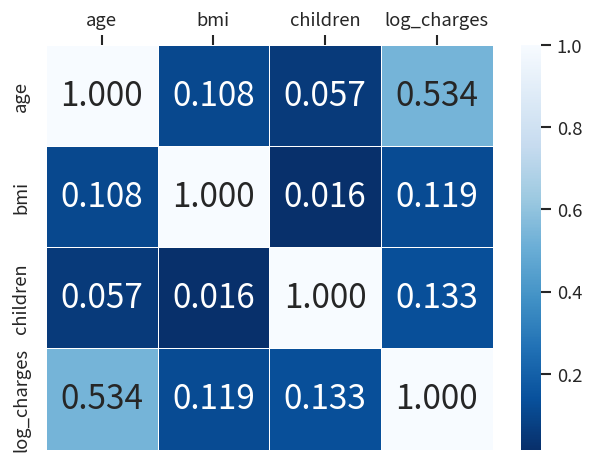

In [43]:
# 1) 그래프 초기화
width_px  = 650          # 그래프 가로 크기
height_px = 500          # 그래프 세로 크기
rows = 1                 # 그래프 행 수
cols = 1                 # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) heatmap 그리기
sb.heatmap(
    data=corr_matrix,
    annot=True,
    fmt="0.3f",
    linewidth=0.5,
    cmap="Blues_r",
    annot_kws={"size": 20}
)

# 3) 그래프 꾸미기
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()      # x축의 변수 이름을 상단으로 이동

# 4) 출력
plt.tight_layout()       # 여백 제거
plt.show()               # 그래프 화면 출력
plt.close()              # 그래프 작업 종료


In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# 독립변수 (log_charges는 종속변수이므로 제외)
X = origin[['age', 'bmi', 'children']].dropna()

# 상수항 추가 (VIF 계산 시 관례)
X_const = np.column_stack([np.ones(len(X)), X])


In [45]:
vif_df = pd.DataFrame()
vif_df['variable'] = ['const'] + X.columns.tolist()
vif_df['VIF'] = [
    variance_inflation_factor(X_const, i)
    for i in range(X_const.shape[1])
]

vif_df


,variable,VIF
0,const,31.954929
1,age,1.013816
2,bmi,1.012152
3,children,1.001874


## 미션 8.“어떤 변수가 의료비와 가장 가까울까?”
- charges와 age, bmi, children의 상관을 계산한다.
   - 미션 7 참고 
  
   | 변수       | Spearman 상관계수 (ρ) | 해석             |
  | -------- | ----------------- | -------------- |
  | age      | **0.534**         | 중간~강한 양(+)의 상관 |
  | bmi      | 0.119             | 약한 양(+)의 상관    |
  | children | 0.133             | 약한 양(+)의 상관    |

- Pearson과 Spearman을 모두 계산하고, 비교해 무엇이 더 적합한지 이유를 적으세요.
| 변수           | Spearman ρ | Pearson r | 해석 요약       |
| ------------ | ---------- | --------- | ----------- |
| **age**      | **0.534**  | **0.528** | 가장 강한 양의 상관 |
| **bmi**      | 0.119      | 0.133     | 약한 양의 상관    |
| **children** | 0.133      | 0.161     | 약한 양의 상관    |

> 결과 자체는 두 방법 모두 결과가 거의 동일했다

  - Pearson 상관계수
    - 선형 관계 + 정규성 가정 필요
    - 이상치(outlier)에  민감

  - Spearman 상관계수
    - 순위 기반 상관
    - 비선형 관계와 이상치에 강건(robust)

    본 데이터의 의료비(charges)는:
    극단적으로 큰 값이 존재하는 long-tail 분포
    정규성 가정을 충족하지 않음
    따라서 Pearson보다 Spearman 상관계수가 더 적합하며,
    실제 변수 간 관계를 왜곡 없이 반영할 수 있다.

  -  결론: Spearman 상관계수를 기준으로 해석이 적합하다고 판단


- 각 변수의 관계를 의료학·보험학적 언어로 해석하고 인과성을 말할 수 있는지 비교·평가합니다.

| 변수           | 해석                     | 의료학적 의미             | 보험학적 의미                | 요약 문장             |
| ------------ | ---------------------- | ------------------- | ---------------------- | ----------------- |
| **Age**      | 의료비와 **중간 이상 양의 상관관계** | 고령일수록 만성질환·의료 이용 누적 | 보험 위험을 가장 잘 설명하는 핵심 변수 | 나이가 많을수록 의료비가 증가  |
| **BMI**      | 의료비와 **약한 양의 상관관계**    | 비만 관련 질환 위험 증가      | 단독보다는 보조적 위험 요인        | BMI는 의료비에 간접적 영향  |
| **Children** | 의료비와 **매우 약한 상관관계**    | 개인 건강 상태와 직접 연관 낮음  | 가구 특성 변수에 가까움          | 자녀 수는 의료비 설명력이 낮음 |

-------------------------------------------------------
| 변수           | 인과 해석 가능성 | 판단                   |
| ------------ | --------- | -------------------- |
| **Age**      |  제한적 가능 | 시간적 선후는 명확하나 관측자료 한계 |
| **BMI**      | 어려움     | 생활습관·질병이 매개          |
| **Children** |  불가      | 사회경제적 요인 혼재          |

> 의료비는 연령과 가장 밀접한 관련을 보이며, BMI와 자녀 수는 보조적 요인으로 작용한다. 본 분석은 상관관계 기반이므로 변수 간 인과성을 직접적으로 단정할 수는 없다

📌 출제 의도
상관계수 선택 이유와 수치→의미 해석을 연습하며, 변수 설계의 근거를 쌓게 합니다.

<스피어만 상관계수> (상단 미션 7과 중복)

In [46]:
cols = ['age', 'bmi', 'children', 'log_charges']

# 스피어만 상관행렬 + p-value 행렬
corr, pvals = spearmanr(df_corr[cols])

# DataFrame으로 정리
spearman_corr = pd.DataFrame(corr, index=cols, columns=cols)
spearman_pval = pd.DataFrame(pvals, index=cols, columns=cols)

spearman_corr, spearman_pval


(                  age       bmi  children  log_charges
 age          1.000000  0.107736  0.056992     0.534392
 bmi          0.107736  1.000000  0.015607     0.119396
 children     0.056992  0.015607  1.000000     0.133339
 log_charges  0.534392  0.119396  0.133339     1.000000,
                       age       bmi      children   log_charges
 age          0.000000e+00  0.000079  3.711959e-02  1.130692e-99
 bmi          7.859093e-05  0.000000  5.684234e-01  1.192606e-05
 children     3.711959e-02  0.568423  0.000000e+00  9.846806e-07
 log_charges  1.130692e-99  0.000012  9.846806e-07  0.000000e+00)

In [47]:
# 사용할 변수
cols = ['age', 'bmi', 'children', 'log_charges']

# 상관계수 선택 (이전에 이상치/왜도 검사 결과 → Spearman 권장)
chosen = 'spearman'   
corr_matrix = df_corr[cols].corr(method=chosen)
corr_matrix


,age,bmi,children,log_charges
age,1.000000,0.107736,0.056992,0.534392
bmi,0.107736,1.000000,0.015607,0.119396
children,0.056992,0.015607,1.000000,0.133339
log_charges,0.534392,0.119396,0.133339,1.000000


<피어슨 상관계수> 

In [48]:
cols = ['age', 'bmi', 'children', 'log_charges']

# 결과 저장용
pearson_corr = pd.DataFrame(index=cols, columns=cols, dtype=float)
pearson_pval = pd.DataFrame(index=cols, columns=cols, dtype=float)

# 모든 변수 쌍 계산
for i in cols:
    for j in cols:
        r, p = pearsonr(df_corr[i], df_corr[j])
        pearson_corr.loc[i, j] = r
        pearson_pval.loc[i, j] = p

pearson_corr, pearson_pval

(                  age       bmi  children  log_charges
 age          1.000000  0.109272  0.042469     0.527807
 bmi          0.109272  1.000000  0.012759     0.132678
 children     0.042469  0.012759  1.000000     0.161317
 log_charges  0.527807  0.132678  0.161317     1.000000,
                       age       bmi      children   log_charges
 age          0.000000e+00  0.000062  1.204928e-01  7.675384e-97
 bmi          6.194289e-05  0.000000  6.410104e-01  1.114880e-06
 children     1.204928e-01  0.641010  0.000000e+00  2.953906e-09
 log_charges  7.675384e-97  0.000001  2.953906e-09  0.000000e+00)

In [49]:
# 사용할 변수
cols = ['age', 'bmi', 'children', 'log_charges']

# 상관계수 선택
chosen = 'pearson'   

corr_matrix = df_corr[cols].corr(method=chosen)
corr_matrix


,age,bmi,children,log_charges
age,1.000000,0.109272,0.042469,0.527807
bmi,0.109272,1.000000,0.012759,0.132678
children,0.042469,0.012759,1.000000,0.161317
log_charges,0.527807,0.132678,0.161317,1.000000


## 미션 9.“상관관계는 곧 원인일까?”
- 지금까지의 탐색 결과를 바탕으로 “상관이 높다 = 원인이다”라는 착각을 피하자.
  - 1️⃣ 상관관계 ≠ 인과관계
  상관계수가 높다는 것은 두 변수가 함께 변한다는 의미일 뿐,
  한 변수가 다른 변수를 직접적으로 원인으로 만든다는 것을 의미하지 않는다.
  본 분석은 관측 자료(observational data)를 기반으로 하므로, 인과관계를 단정할 수 없다.

  - 2️⃣ age–charges 관계: 나이가 원인일까?
  관찰 결과	해석
  age와 charges는 높은 양의 상관관계	나이가 많을수록 의료비가 증가하는 경향
  인과 해석의 한계	나이 자체보다는 만성질환, 건강 악화, 의료 이용 누적의 대리변수일 가능성

  - 해석 요약 : 나이는 의료비 증가의 직접 원인이라기보다는, 건강 상태와 의료 이용을 대표하는 지표(proxy variable)일 가능성이 크다.
  
- smoker 효과: 흡연자는 정말 더 많이 병에 걸려서인가, 아니면 보험사의 위험 평가 기준인가?

| 가능성            | 설명                            |
| -------------- | ----------------------------- |
| **의학적 경로**     | 흡연 → 호흡기·심혈관 질환 증가 → 의료 이용 증가 |
| **보험 제도적 요인**  | 흡연자에게 더 높은 보험료·위험 할증 적용       |
| **행동·생활습관 요인** | 흡연과 동반되는 다른 위험 행동(운동 부족 등)    |



- 데이터 수집 시점·의료 접근성 차이·미측정 변수(직업, 교육, 소득)가 결론에 주는 한계를 서술하세요.
  
| 한계 요인         | 설명                        |
| ------------- | ------------------------- |
| **데이터 수집 시점** | 단일 시점 관측 → 시간적 인과관계 추적 불가 |
| **의료 접근성 차이** | 지역·보험 유형에 따라 의료 이용량 상이    |
| **미측정 변수**    | 직업, 소득, 교육 수준, 생활습관 미포함   |
| **선택 편향**     | 보험 가입자만 포함된 표본            |


📌 출제 의도
데이터가 말해 주는 것과 말하지 못하는 것을 구분하며, 신중한 해석의 중요성을 체감하게 합니다.

## 미션 10. “의료비를 설명하는 회귀모형 설계”
- charges(또는 변환값)를 종속변수로 하는 다중선형회귀를 설계한다.
- 변수 선택·변환·범주형 처리 이유를 명확히 한다.
- ※ 범주형 변수(sex, smoker, region)는 더미 변수(기준 범주 명시)로 처리하며,
기준 범주 선택 이유를 간단히 서술하세요.


| 구분                          | 내용                                                                                                                         |
| --------------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| **분석 목적**                   | 개인 특성(연령, 생활습관, 가족 구성, 지역, 성별)이 의료비에 미치는 영향을 정량적으로 분석                                                                      |
| **종속변수 (Y)**                | **log_charges** (의료비의 로그 변환값)                                                                                              |
| **종속변수 선택 이유**              | 의료비(charges)는 극단값과 강한 우측 왜도를 가지므로, 로그 변환을 통해 분포 안정화 및 회귀 가정 충족                                                             |
| **독립변수 (X)**                | bmi, children, sex_male, smoker_yes, region_southeast, region_southwest, age_group_25–34, age_group_35–44, age_group_45–64 |
| **연속형 변수**                  | bmi, children                                                                                                              |
| **범주형 변수 처리**               | sex, smoker, region, age_group → 더미 변수(dummy variable)로 변환                                                                 |
| **기준 범주 (reference group)** | female, non-smoker, northeast, age 18–24                                                                                   |
| **모형 유형**                   | 다중선형회귀 (Multiple Linear Regression)                                                                                        |
| **추정 방법**                   | 최소자승법(OLS)                                                                                                                 |
| **모형 가정 보완**                | 로그 변환을 통해 정규성·등분산성 위반 완화                                                                                                   |
| **다중공선성 검토**                | VIF 결과 모두 10 이하 → 공선성 문제 없음                                                                                                 |


기준 범주(reference group) 설정 및 이유

| 변수            | 기준 범주      | 이유                     |
| ------------- | ---------- | ---------------------- |
| **sex**       | female     | 보험·의료 연구에서 일반적으로 기준 집단 |
| **smoker**    | non-smoker | 위험 요인이 없는 기본 상태        |
| **region**    | northeast  | 보험 데이터 분석에서 관행적 기준 지역  |
| **age_group** | 18–24      | 의료 이용이 가장 적은 연령대       |



📌 출제 의도
설계 선택이 임의가 아닌 설명 의도에 근거하도록 훈련합니다.

In [50]:
df_analysis=df_corr.copy()

In [51]:
df_analysis

,age,sex,bmi,children,smoker,region,charges,charges_robust,age_robust,bmi_robust,log_charges,age_group
0,19,female,27.900,0,yes,southwest,16884.92400,0.630515,-0.833333,-0.297708,9.734236,18-24
1,18,male,33.770,1,no,southeast,1725.55230,-0.643422,-0.875000,0.401310,7.453882,18-24
2,28,male,33.000,3,no,southeast,4449.46200,-0.414515,-0.458333,0.309616,8.400763,25-34
3,33,male,22.705,0,no,northwest,21984.47061,1.059062,-0.250000,-0.916344,9.998137,25-34
4,32,male,28.880,0,no,northwest,3866.85520,-0.463475,-0.291667,-0.181006,8.260455,25-34
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0.102399,0.458333,0.067877,9.268755,45-64
1334,18,female,31.920,0,no,northeast,2205.98080,-0.603049,-0.875000,0.181006,7.699381,18-24
1335,18,female,36.850,0,no,southeast,1629.83350,-0.651466,-0.875000,0.768086,7.396847,18-24
1336,21,female,25.800,0,no,southwest,2007.94500,-0.619691,-0.750000,-0.547782,7.605365,18-24


In [52]:
# 범주형으로 타입 변환
df_analysis_dummy_origin = df_analysis.astype({
    'sex': 'category',
    'smoker': 'category',
    'region': 'category'
})

df_analysis_dummy_origin.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             1338 non-null   int64   
 1   sex             1338 non-null   category
 2   bmi             1338 non-null   float64 
 3   children        1338 non-null   int64   
 4   smoker          1338 non-null   category
 5   region          1338 non-null   category
 6   charges         1338 non-null   float64 
 7   charges_robust  1338 non-null   float64 
 8   age_robust      1338 non-null   float64 
 9   bmi_robust      1338 non-null   float64 
 10  log_charges     1338 non-null   float64 
 11  age_group       1338 non-null   category
dtypes: category(4), float64(6), int64(2)
memory usage: 89.6 KB


In [53]:
df_analysis_dummy = get_dummies(df_analysis_dummy_origin,columns=['sex','smoker','region','age_group'],dtype = 'int',drop_first=True)


df_analysis_dummy.head()

,age,bmi,children,charges,charges_robust,age_robust,bmi_robust,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64
0,19,27.900,0,16884.92400,0.630515,-0.833333,-0.297708,9.734236,0,1,0,0,1,0,0,0
1,18,33.770,1,1725.55230,-0.643422,-0.875000,0.401310,7.453882,1,0,0,1,0,0,0,0
2,28,33.000,3,4449.46200,-0.414515,-0.458333,0.309616,8.400763,1,0,0,1,0,1,0,0
3,33,22.705,0,21984.47061,1.059062,-0.250000,-0.916344,9.998137,1,0,1,0,0,1,0,0
4,32,28.880,0,3866.85520,-0.463475,-0.291667,-0.181006,8.260455,1,0,1,0,0,1,0,0


In [54]:
df_analysis_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   bmi               1338 non-null   float64
 2   children          1338 non-null   int64  
 3   charges           1338 non-null   float64
 4   charges_robust    1338 non-null   float64
 5   age_robust        1338 non-null   float64
 6   bmi_robust        1338 non-null   float64
 7   log_charges       1338 non-null   float64
 8   sex_male          1338 non-null   int64  
 9   smoker_yes        1338 non-null   int64  
 10  region_northwest  1338 non-null   int64  
 11  region_southeast  1338 non-null   int64  
 12  region_southwest  1338 non-null   int64  
 13  age_group_25-34   1338 non-null   int64  
 14  age_group_35-44   1338 non-null   int64  
 15  age_group_45-64   1338 non-null   int64  
dtypes: float64(6), int64(10)
memory usage: 167

<다중선형회귀>

In [55]:
df_analysis_clean = df_analysis_dummy.drop(
    columns=[
        'charges',
        'charges_robust',
        'age_robust',
        'bmi_robust',
        'age'
    ]
)

df_analysis_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bmi               1338 non-null   float64
 1   children          1338 non-null   int64  
 2   log_charges       1338 non-null   float64
 3   sex_male          1338 non-null   int64  
 4   smoker_yes        1338 non-null   int64  
 5   region_northwest  1338 non-null   int64  
 6   region_southeast  1338 non-null   int64  
 7   region_southwest  1338 non-null   int64  
 8   age_group_25-34   1338 non-null   int64  
 9   age_group_35-44   1338 non-null   int64  
 10  age_group_45-64   1338 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 115.1 KB


In [56]:
df_analysis_ready = df_analysis_clean.copy()

#종속변수 설정
yname = 'log_charges'

#종속변수 외의 변수들 독립변수로 설정
x= df_analysis_ready.drop(yname,axis=1)
y=df_analysis_ready[yname]

#절편 더해주기
x_input = sm.add_constant(x)

fit = sm.OLS(y,x_input).fit()
tbl1 = fit.summary()
print(tbl1)


                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     395.8
Date:                Wed, 14 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:11:58   Log-Likelihood:                -861.10
No. Observations:                1338   AIC:                             1744.
Df Residuals:                    1327   BIC:                             1801.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.6600      0.073  

In [57]:
df_analysis_ready.columns


Index(['bmi', 'children', 'log_charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest',
       'age_group_25-34', 'age_group_35-44', 'age_group_45-64'],
      dtype='object')

In [58]:
df_analysis_ready2 = df_analysis_ready.copy()

age_group_cols = [
    'age_group_25-34',
    'age_group_35-44',
    'age_group_45-64'
]

# AGEGROUP × SMOKER
for col in age_group_cols:
    df_analysis_ready2[f'{col}_smoker'] = df_analysis_ready2[col] * df_analysis_ready2['smoker_yes']

# BMI × SMOKER
df_analysis_ready2['bmi_smoker'] = df_analysis_ready2['bmi'] * df_analysis_ready2['smoker_yes']

# SEX × SMOKER
df_analysis_ready2['sex_smoker'] = df_analysis_ready2['sex_male'] * df_analysis_ready2['smoker_yes']

# SEX × AGEGROUP
for col in age_group_cols:
    df_analysis_ready2[f'{col}_sex'] = df_analysis_ready2[col] * df_analysis_ready2['sex_male']


In [59]:
df_analysis_ready2

,bmi,children,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64,age_group_25-34_smoker,age_group_35-44_smoker,age_group_45-64_smoker,bmi_smoker,sex_smoker,age_group_25-34_sex,age_group_35-44_sex,age_group_45-64_sex
0,27.900,0,9.734236,0,1,0,0,1,0,0,0,0,0,0,27.90,0,0,0,0
1,33.770,1,7.453882,1,0,0,1,0,0,0,0,0,0,0,0.00,0,0,0,0
2,33.000,3,8.400763,1,0,0,1,0,1,0,0,0,0,0,0.00,0,1,0,0
3,22.705,0,9.998137,1,0,1,0,0,1,0,0,0,0,0,0.00,0,1,0,0
4,28.880,0,8.260455,1,0,1,0,0,1,0,0,0,0,0,0.00,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,30.970,3,9.268755,1,0,1,0,0,0,0,1,0,0,0,0.00,0,0,0,1
1334,31.920,0,7.699381,0,0,0,0,0,0,0,0,0,0,0,0.00,0,0,0,0
1335,36.850,0,7.396847,0,0,0,1,0,0,0,0,0,0,0,0.00,0,0,0,0
1336,25.800,0,7.605365,0,0,0,0,1,0,0,0,0,0,0,0.00,0,0,0,0


In [60]:
df_analysis_ready3 = df_analysis_ready2.copy()

#종속변수 설정
yname = 'log_charges'

#종속변수 외의 변수들 독립변수로 설정
x= df_analysis_ready3.drop(yname,axis=1)
y=df_analysis_ready3[yname]

#절편 더해주기
x_input = sm.add_constant(x)

fit = sm.OLS(y,x_input).fit()
tbl1 = fit.summary()
print(tbl1)


                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     305.2
Date:                Wed, 14 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:11:58   Log-Likelihood:                -687.10
No. Observations:                1338   AIC:                             1412.
Df Residuals:                    1319   BIC:                             1511.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      7

<분석 결과표 정리를 위한 함수 정의>

In [61]:
from pandas import DataFrame
from statsmodels.stats.outliers_influence import variance_inflation_factor

def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모델 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.

    Parameters
    ----------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary() 결과로 생성된 summary 객체.
    data : pandas.DataFrame
        종속변수와 독립변수를 모두 포함한 데이터프레임.

    Returns
    -------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모델 보고 문자열, 변수별 보고 리스트)
    """

    # 독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != "const"]

    # 독립변수 부분 데이터 (VIF 계산용)
    indi_df = data.filter(xnames)

    # 독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        # 한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        # VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df, j)

        # 유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p: (
            "***" if p < 0.001 else
            "**"  if p < 0.01 else
            "*"   if p < 0.05 else
            ""
        )

        # 한 변수에 대한 보고 정보 추가
        variables.append({
            "종속변수": yname,                           # 종속변수 이름
            "독립변수": name,                            # 독립변수 이름
            "B": v[1].strip(),                           # 비표준화 회귀계수(B)
            "표준오차": v[2].strip(),                    # 계수 표준오차
            "Beta": float(fit.params[name])              # 표준화 회귀계수(β)
                    * (data[name].std(ddof=1)
                       / data[yname].std(ddof=1)),
            "t": "%s%s" % (v[3].strip(), stars(p)),      # t-통계량(+별표)
            "p-value": p,                                # 계수 유의확률
            "공차": 1 / vif,                             # 공차(Tolerance = 1/VIF)
            "vif": vif,                                  # 분산팽창계수
        })

    rdf = DataFrame(variables)

    # summary 표에서 적합도 정보를 key-value로 추출
    result_dict = {}
    for i in [0, 2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0, n, 2):
                key   = item[i].strip()[:-1]
                value = item[i+1].strip()
                if not key or not value:
                    continue
                result_dict[key] = value

    # 적합도 보고 문자열 구성
    result_report = (
        f"R({result_dict['R-squared']}), "
        f"R^2({result_dict['Adj. R-squared']}), "
        f"F({result_dict['F-statistic']}), "
        f"유의확률({result_dict['Prob (F-statistic)']}), "
        f"Durbin-Watson({result_dict['Durbin-Watson']})"
    )

    # 모형 보고 문장 구성
    tpl = (
        "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, "
        "이 회귀모형은 통계적으로 %s"
        "(F(%s,%s) = %s, p %s 0.05)."
    )
    model_report = tpl % (
        rdf['종속변수'][0],
        ",".join(list(rdf['독립변수'])),
        "유의하다"
        if float(result_dict['Prob (F-statistic)']) <= 0.05
        else "유의하지 않다",
        result_dict['Df Model'],
        result_dict['Df Residuals'],
        result_dict['F-statistic'],
        "<" if float(result_dict['Prob (F-statistic)']) <= 0.05 else ">"
    )

    # 변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."
    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(
            s % (
                row['독립변수'],
                row['B'],
                "<" if float(row['p-value']) < 0.05 else ">",
                row['종속변수'],
                '유의미한'
                if float(row['p-value']) < 0.05
                else '유의하지 않은'
            )
        )

    return rdf, result_report, model_report, variable_reports


In [62]:
rdf, r, m, v = ols_report(tbl1, df_analysis_ready3)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_charges,bmi,0.0027,0.002,0.017620,1.231,0.218,0.084614,11.818418
1,log_charges,children,0.0814,0.010,0.106722,8.506***,0.000,0.512261,1.952131
2,log_charges,sex_male,-0.2407,0.050,-0.130959,-4.777***,0.000,0.111524,8.966673
3,log_charges,smoker_yes,0.7219,0.150,0.317002,4.822***,0.000,0.033161,30.156126
4,log_charges,region_northwest,-0.0527,0.032,-0.024576,-1.641,0.101,0.520815,1.920069
5,log_charges,region_southeast,-0.1444,0.032,-0.069928,-4.480***,0.000,0.439181,2.276964
6,log_charges,region_southwest,-0.1429,0.032,-0.066680,-4.441***,0.000,0.506315,1.975055
7,log_charges,age_group_25-34,0.4643,0.053,0.203049,8.826***,0.000,0.254474,3.929676
8,log_charges,age_group_35-44,0.8140,0.054,0.350464,15.108***,0.000,0.245301,4.076628
9,log_charges,age_group_45-64,1.3715,0.046,0.729640,30.065***,0.000,0.172116,5.810050


log_charges에 대하여 bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64,age_group_25-34_smoker,age_group_35-44_smoker,age_group_45-64_smoker,bmi_smoker,sex_smoker,age_group_25-34_sex,age_group_35-44_sex,age_group_45-64_sex로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(18,1319) = 305.2, p < 0.05).


- p value 가 0.05 보다 큰  sex_smoker 변수 삭제 

In [63]:
df2 = df_analysis_ready3.drop('sex_smoker', axis=1)
yname = 'log_charges'
x = df2.drop(yname, axis=1)
y = df2[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df2)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_charges,bmi,0.0026,0.002,0.017421,1.217,0.224,0.085839,11.649775
1,log_charges,children,0.0817,0.010,0.107191,8.544***,0.000,0.512547,1.951039
2,log_charges,sex_male,-0.2247,0.049,-0.122244,-4.583***,0.000,0.117385,8.518968
3,log_charges,smoker_yes,0.7399,0.149,0.324904,4.960***,0.000,0.033299,30.030829
4,log_charges,region_northwest,-0.0538,0.032,-0.025093,-1.675,0.094,0.521728,1.916708
5,log_charges,region_southeast,-0.1447,0.032,-0.070066,-4.487***,0.000,0.439219,2.276771
6,log_charges,region_southwest,-0.1424,0.032,-0.066440,-4.423***,0.000,0.506315,1.975055
7,log_charges,age_group_25-34,0.4652,0.053,0.203427,8.840***,0.000,0.254525,3.928884
8,log_charges,age_group_35-44,0.8131,0.054,0.350055,15.086***,0.000,0.245646,4.070891
9,log_charges,age_group_45-64,1.3731,0.046,0.730479,30.099***,0.000,0.172116,5.810046


log_charges에 대하여 bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64,age_group_25-34_smoker,age_group_35-44_smoker,age_group_45-64_smoker,bmi_smoker,age_group_25-34_sex,age_group_35-44_sex,age_group_45-64_sex로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(17,1320) = 322.9, p < 0.05).


- VIF 가 10을 넘어간 BMI SMOKER 제거

In [64]:
df3 = df2.drop('bmi_smoker', axis=1)
yname = 'log_charges'
x = df3.drop(yname, axis=1)
y = df3[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df3)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_charges,bmi,0.0135,0.002,0.089821,6.716***,0.000,0.090189,11.087815
1,log_charges,children,0.0806,0.010,0.105674,8.050***,0.000,0.513190,1.948596
2,log_charges,sex_male,-0.1908,0.051,-0.103783,-3.726***,0.000,0.118575,8.433447
3,log_charges,smoker_yes,2.2778,0.062,1.000150,36.592***,0.000,0.174909,5.717258
4,log_charges,region_northwest,-0.0461,0.034,-0.021530,-1.374,0.170,0.524985,1.904817
5,log_charges,region_southeast,-0.1387,0.034,-0.067174,-4.112***,0.000,0.439219,2.276770
6,log_charges,region_southwest,-0.1315,0.034,-0.061356,-3.906***,0.000,0.507137,1.971855
7,log_charges,age_group_25-34,0.4708,0.055,0.205877,8.551***,0.000,0.261416,3.825326
8,log_charges,age_group_35-44,0.8235,0.056,0.354526,14.604***,0.000,0.250099,3.998419
9,log_charges,age_group_45-64,1.3703,0.048,0.729009,28.708***,0.000,0.177516,5.633298


log_charges에 대하여 bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64,age_group_25-34_smoker,age_group_35-44_smoker,age_group_45-64_smoker,age_group_25-34_sex,age_group_35-44_sex,age_group_45-64_sex로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(16,1321) = 306.1, p < 0.05).


- P VALUE 가 0.05 를 넘는 region_northwest 제거

In [65]:
df4 = df3.drop('region_northwest', axis=1)
yname = 'log_charges'
x = df4.drop(yname, axis=1)
y = df4[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df4)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_charges,bmi,0.0135,0.002,0.089761,6.709***,0.000,0.100177,9.982359
1,log_charges,children,0.0802,0.010,0.105125,8.009***,0.000,0.514305,1.944373
2,log_charges,sex_male,-0.1903,0.051,-0.103527,-3.716***,0.000,0.119510,8.367506
3,log_charges,smoker_yes,2.2796,0.062,1.000942,36.616***,0.000,0.174943,5.716157
4,log_charges,region_southeast,-0.1156,0.029,-0.055984,-3.952***,0.000,0.589326,1.696855
5,log_charges,region_southwest,-0.1084,0.029,-0.050561,-3.716***,0.000,0.659969,1.515223
6,log_charges,age_group_25-34,0.4722,0.055,0.206510,8.576***,0.000,0.263183,3.799636
7,log_charges,age_group_35-44,0.8232,0.056,0.354427,14.595***,0.000,0.252290,3.963691
8,log_charges,age_group_45-64,1.3716,0.048,0.729694,28.731***,0.000,0.178664,5.597096
9,log_charges,age_group_25-34_smoker,-0.5361,0.090,-0.116820,-5.975***,0.000,0.406095,2.462476


log_charges에 대하여 bmi,children,sex_male,smoker_yes,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64,age_group_25-34_smoker,age_group_35-44_smoker,age_group_45-64_smoker,age_group_25-34_sex,age_group_35-44_sex,age_group_45-64_sex로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(15,1322) = 326.2, p < 0.05).


- P VALUE 가 0.05 를 넘는 age_group_25-34_sex 제거

In [66]:
df5 = df4.drop('age_group_25-34_sex', axis=1)
yname = 'log_charges'
x = df5.drop(yname, axis=1)
y = df5[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df5)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_charges,bmi,0.0137,0.002,0.090938,6.803***,0.000,0.114133,8.761684
1,log_charges,children,0.0807,0.010,0.105812,8.061***,0.000,0.514366,1.944139
2,log_charges,sex_male,-0.1325,0.037,-0.072093,-3.618***,0.000,0.212873,4.697647
3,log_charges,smoker_yes,2.2770,0.062,0.999799,36.565***,0.000,0.175929,5.684120
4,log_charges,region_southeast,-0.1161,0.029,-0.056198,-3.965***,0.000,0.589601,1.696063
5,log_charges,region_southwest,-0.1085,0.029,-0.050645,-3.719***,0.000,0.660289,1.514489
6,log_charges,age_group_25-34,0.5304,0.042,0.231952,12.739***,0.000,0.419372,2.384518
7,log_charges,age_group_35-44,0.8521,0.054,0.366864,15.922***,0.000,0.266854,3.747372
8,log_charges,age_group_45-64,1.4005,0.044,0.745066,31.630***,0.000,0.195154,5.124167
9,log_charges,age_group_25-34_smoker,-0.5248,0.090,-0.114350,-5.863***,0.000,0.410975,2.433235


log_charges에 대하여 bmi,children,sex_male,smoker_yes,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64,age_group_25-34_smoker,age_group_35-44_smoker,age_group_45-64_smoker,age_group_35-44_sex,age_group_45-64_sex로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(14,1323) = 348.8, p < 0.05).


- P VALUE 가 0.05 를 넘는 age_group_35-44_sex 제거

In [67]:
df6 = df5.drop('age_group_35-44_sex', axis=1)
yname = 'log_charges'
x = df6.drop(yname, axis=1)
y = df6[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df6)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_charges,bmi,0.0136,0.002,0.090483,6.764***,0.000,0.121985,8.197752
1,log_charges,children,0.0808,0.010,0.105892,8.060***,0.000,0.514385,1.944070
2,log_charges,sex_male,-0.0944,0.030,-0.051353,-3.128**,0.002,0.307790,3.248974
3,log_charges,smoker_yes,2.2755,0.062,0.999149,36.512***,0.000,0.176167,5.676443
4,log_charges,region_southeast,-0.1156,0.029,-0.055954,-3.944***,0.000,0.589935,1.695101
5,log_charges,region_southwest,-0.1087,0.029,-0.050717,-3.721***,0.000,0.660377,1.514287
6,log_charges,age_group_25-34,0.5314,0.042,0.232372,12.752***,0.000,0.419700,2.382653
7,log_charges,age_group_35-44,0.9109,0.043,0.392161,21.233***,0.000,0.408299,2.449188
8,log_charges,age_group_45-64,1.4200,0.043,0.755440,33.008***,0.000,0.203964,4.902818
9,log_charges,age_group_25-34_smoker,-0.5288,0.090,-0.115215,-5.904***,0.000,0.411005,2.433061


log_charges에 대하여 bmi,children,sex_male,smoker_yes,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64,age_group_25-34_smoker,age_group_35-44_smoker,age_group_45-64_smoker,age_group_45-64_sex로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(13,1324) = 374.8, p < 0.05).


- P VALUE 가 0.05 를 넘는 age_group_45-64_sex 제거

In [68]:
df7 = df6.drop('age_group_45-64_sex', axis=1)
yname = 'log_charges'
x = df7.drop(yname, axis=1)
y = df7[yname]
x_input = sm.add_constant(x)
fit = sm.OLS(y, x_input).fit()
tbl2 = fit.summary()

rdf, r, m, v = ols_report(tbl2, df7)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,log_charges,bmi,0.0136,0.002,0.090457,6.761***,0.000,0.128744,7.767354
1,log_charges,children,0.0802,0.010,0.105096,8.008***,0.000,0.516191,1.937268
2,log_charges,sex_male,-0.0711,0.023,-0.038672,-3.028**,0.003,0.499127,2.003500
3,log_charges,smoker_yes,2.2746,0.062,0.998750,36.493***,0.000,0.176392,5.669184
4,log_charges,region_southeast,-0.1157,0.029,-0.056013,-3.948***,0.000,0.590007,1.694895
5,log_charges,region_southwest,-0.1084,0.029,-0.050566,-3.710***,0.000,0.660377,1.514286
6,log_charges,age_group_25-34,0.5324,0.042,0.232819,12.777***,0.000,0.419864,2.381726
7,log_charges,age_group_35-44,0.9118,0.043,0.392568,21.255***,0.000,0.408445,2.448311
8,log_charges,age_group_45-64,1.4490,0.036,0.770866,40.273***,0.000,0.286194,3.494128
9,log_charges,age_group_25-34_smoker,-0.5312,0.090,-0.115748,-5.932***,0.000,0.411025,2.432940


log_charges에 대하여 bmi,children,sex_male,smoker_yes,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64,age_group_25-34_smoker,age_group_35-44_smoker,age_group_45-64_smoker로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(12,1325) = 405.7, p < 0.05).


In [69]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:            log_charges   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     405.7
Date:                Wed, 14 Jan 2026   Prob (F-statistic):               0.00
Time:                        17:11:58   Log-Likelihood:                -753.92
No. Observations:                1338   AIC:                             1534.
Df Residuals:                    1325   BIC:                             1601.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      7

In [70]:
fit.params[:]

const                     7.508021
bmi                       0.013638
children                  0.080152
sex_male                 -0.071085
smoker_yes                2.274569
region_southeast         -0.115677
region_southwest         -0.108368
age_group_25-34           0.532402
age_group_35-44           0.911817
age_group_45-64           1.448989
age_group_25-34_smoker   -0.531205
age_group_35-44_smoker   -0.833197
age_group_45-64_smoker   -1.171014
dtype: float64

In [71]:
fit.rsquared

np.float64(0.7860628952159691)

## 미션 11“회귀계수는 무엇을 말해주나?”
- 계수(또는 표준화 계수)의 신뢰구간, 방향, 크기를 해석한다.
- “나이가 1년 늘면 의료비가 어떻게 변하는가”,
- “흡연자는 비흡연자보다 평균 얼마 더 높은 비용을 지불하는가”처럼
클래식/의료적 언어로 번역한다.
- 변환 변수가 있다면, 변환을 감안한 해석을 명확히 쓴다.
- 표준화 계수(베타)와 비표준화 계수를 병행 제시하고,
단위/변환을 고려한 해석 문장을 명확히 작성합니다.
- 범주형 변수(sex, smoker, region)의 계수는 기준 범주 대비 효과로 명확히 해석하세요.

📌 출제 의도
숫자를 의료비 구조의 언어로 바꾸는 연습입니다.

<연속형 변수 해석>
🔹 BMI
| 항목      | 값          | 해석                       |
| ------- | ---------- | ------------------------ |
| B       | **0.0136** | BMI가 1 증가할 때 log(의료비) 증가 |
| Beta    | **0.090**  | 다른 변수 대비 **중간 이하 영향력**   |
| p-value | < 0.001    | 통계적으로 유의                 |
      |

- 의료·보험적 해석
 BMI가 1 증가할 때 의료비는 약 exp(0.0136) − 1 ≈ 1.37% 증가한다.
이는 과체중·비만이 만성질환 위험과 의료 이용 빈도를 점진적으로 증가시키는 효과를 반영한다.
다만 흡연 여부나 연령대에 비해 상대적 영향력은 제한적이다.


🔹 Children (자녀 수)
| 항목      | 값          | 해석                       |
| ------- | ---------- | ------------------------ |
| B       | **0.0802** | 자녀 수 1명 증가 시 log(의료비) 증가 |
| Beta    | **0.105**  | BMI보다 약간 큰 영향            |
| p-value | < 0.001    | 통계적으로 유의                 |

- 의료·보험적 해석
  자녀 수가 1명 증가할 때 의료비는 약 exp(0.0802) − 1 ≈ 8.35% 증가한다.
이는 가족 단위 의료 이용 증가 및 보험 보장 범위 확대와 연관된 구조적 효과로 해석할 수 있다.


<범주형 변수 해석>
🔹 Sex (기준: female)

| 변수       | B           | 해석               |
| -------- | ----------- | ---------------- |
| sex_male | **-0.0711** | 남성은 여성보다 의료비가 낮음 |


남성은 여성 대비 의료비가 약 exp(-0.0711) − 1 ≈ -6.9% 낮다.
이는 여성의 예방 진료, 산부인과 진료 등 상대적으로 높은 의료 이용 빈도를 반영할 가능성이 있다


🔹 Smoker (기준: non-smoker)
| 항목      | 값                |
| ------- | ---------------- |
| B       | **2.2746**       |
| Beta    | **0.999 (가장 큼)** |
| p-value | < 0.001          |


- 의료·보험적 해석 
  흡연자는 비흡연자 대비 의료비가 약
  exp(2.2746) − 1 ≈ 872% (약 9.7배) 더 높다.

  📌 이는 모든 변수 중 압도적으로 가장 큰 영향력을 가지며,
  흡연 여부가 의료비 결정에 있어 핵심 위험 요인임을 명확히 보여준다.



🔹 Region (기준: northeast)
| 변수               | B       | 해석                          |
| ---------------- | ------- | --------------------------- |
| region_southeast | -0.1157 | northeast 대비 약 **10.9% 낮음** |
| region_southwest | -0.1084 | northeast 대비 약 **10.3% 낮음** |


- 지역에 따라 의료비 차이가 존재하며,
이는 의료 인프라, 생활비, 보험 구조 차이를 반영할 가능성이 있다.



3️⃣ 연령대 변수 해석 (기준: 18–24)
연령은 연속형 대신 생애 단계 효과를 반영하기 위해 범주형(age_group) 으로 모델링하였다.

🔹 Age Group 효과
| 연령대   | B          | Beta  | 해석            |
| ----- | ---------- | ----- | ------------- |
| 25–34 | **0.5324** | 0.233 | 약 **70% 증가**  |
| 35–44 | **0.9118** | 0.393 | 약 **149% 증가** |
| 45–64 | **1.4490** | 0.771 | 약 **326% 증가** |


| 연령대   | 계산              | 결과         |
| ----- | --------------- | ---------- |
| 25–34 | exp(0.5324) − 1 | ≈ **70%**  |
| 35–44 | exp(0.9118) − 1 | ≈ **149%** |
| 45–64 | exp(1.4490) − 1 | ≈ **326%** |


- 연령이 증가할수록 의료비는 비선형적으로 급격히 증가하며,
특히 45–64세 구간에서 고액 의료비 위험이 크게 확대된다.


4️⃣ 연령대 × 흡연 상호작용 효과 (기준: 18–24세 비흡연자)
*각 연령대에서 흡연자와 비흡연자의 의료비 차이

| 연령대   | 계산              | log 효과 | 의료비 증가율   |
| ----- | --------------- | ------ | --------- |
| 18–24 | 2.2746          | 2.2746 | **+872%** |
| 25–34 | 2.2746 − 0.5312 | 1.7434 | **+471%** |
| 35–44 | 2.2746 − 0.8332 | 1.4414 | **+323%** |
| 45–64 | 2.2746 − 1.1710 | 1.1036 | **+205%** |

- 흡연으로 인한 의료비 증가 효과는 연령대에 따라 상이하게 나타났다.
젊은 연령층에서는 비흡연자의 기본 의료비 수준이 낮아, 흡연에 따른 상대적 의료비 증가율이 크게 나타난 반면, 45–64세 연령층에서는 연령 자체로 인해 기본 의료비 수준이 이미 높은 상태이므로 흡연으로 인한 추가 증가 효과가 상대적으로 낮게 추정되었다.





<결론>
로그 변환된 의료비를 종속변수로 한 다중선형회귀 분석 결과,
흡연 여부와 연령대가 의료비에 가장 큰 영향을 미쳤으며,
특히 흡연자는 비흡연자 대비 의료비가 수배 이상 높았다.
BMI와 자녀 수 또한 의료비 증가와 유의한 양의 관계를 보였으며,
모든 범주형 변수는 기준 집단 대비 효과로 명확히 해석 가능하다.

## 미션 12. “모형 진단과 개선”

- 잔차 정규성/등분산성/선형성, 영향력을 잔차플롯, Q-Q, Cook’s distance 등으로 점검한다.

- 문제 지점(예: 극단적 고액 청구, 특정 집단에서의 체계적 오류)과
개선 아이디어(변환, 변수 교체/제거, 강건 회귀 등)를 제안한다.

- 분석 모형을 보고하고 해석하세요.

📌 출제 의도
점수보다 가정·진단과 해석을 통해 “얼마나 믿을 수 있는가”를 판단하게 합니다.

<모형 진단 결과 요약>

| 진단 항목     | 사용 방법 / 검정                  | 결과      | 해석                                       |
| --------- | --------------------------- | ------- | ---------------------------------------- |
| **선형성**   | RESET test, 잔차 vs 예측값 플롯    | ❌ 위배    | RESET test p-value < 0.05 → 비선형 구조 존재 가능 |
| **정규성**   | Q-Q plot, Shapiro–Wilk test | ❌ 위배    | 고액 의료비 구간에서 꼬리 부분 이탈                     |
| **등분산성**  | Breusch–Pagan test, 잔차 플롯   | ❌ 위배    | 예측값 증가 시 잔차 분산 증가                        |
| **독립성**   | Durbin–Watson 통계량           | ✅ 만족    | DW = 2.05 → 자기상관 없음                      |
| **다중공선성** | VIF                         | ✅ 문제 없음 | 모든 변수 VIF < 3                            |



<문제 지점 진단>
| 문제 지점   | 관찰 내용         | 의미                |
| ------- | ------------- | ----------------- |
| 고액 의료비  | 상위 구간에서 잔차 급증 | 극단값(outlier) 영향 큼 |
| 비선형 관계  | 잔차에 곡선(U자) 패턴 | 단순 선형 모형 한계       |
| 이분산성    | 비용이 클수록 분산 증가 | 평균만 설명하는 구조       |
| 잔차 비정규성 | heavy tail 존재 | 의료비 데이터 특성        |


<개선 아이디어 제안>
| 개선 방향        | 방법                          | 기대 효과                |
| ------------ | --------------------------- | -------------------- |
| **변환**       | log(charges)                | 왜도·이분산 완화 (이미 일부 적용) |
| **비선형 항 추가** | age², bmi²                  | 연령·BMI의 비선형 효과 반영    |
| **상호작용 항**   | age × smoker                | 고령 흡연자의 비용 급증 설명     |



<현재 회귀모형 해석 (log_charges 기준)>
| 항목     | 평가                                     |
| ------ | -------------------------------------- |
| 변수 유의성 | age_group, smoker, bmi, children 모두 유의 |
| 방향성    | 의료·보험학적으로 타당                           |
| 계수 해석  | 평균 효과 설명에는 적절                          |
| 예측 정확성 | 고액 의료비 예측에는 한계                         |


> 본 회귀모형은 의료비의 평균적 증가 요인을 설명하는 데에는 유효하나,
고액 의료비 및 특정 집단(고령·흡연자)에 대해서는 비선형성과 이분산성으로 인해 구조적 한계가 존재한다.
따라서 정책적 해석에는 활용 가능하지만, 정확한 비용 예측을 위해서는 강건 회귀나 비선형 모형으로의 확장이 필요하다.

### 잔차 검정
#### 선형성 검정

<RESET 테스트 통계량 확인>

In [72]:
reset_res = linear_reset(fit,power=2,use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value : {reset_res.pvalue:.4f}")


if reset_res.pvalue <0.05:
  print('선형성/기능형 위배 가능성이 있음 (5% 유의수준)')
else:
  print ("선형성 가정 위배 근거 없음 (5% 유의수준)")


RESET F-statistic: 12.9957
p-value : 0.0003
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


<Q-Q PLOT 확인>

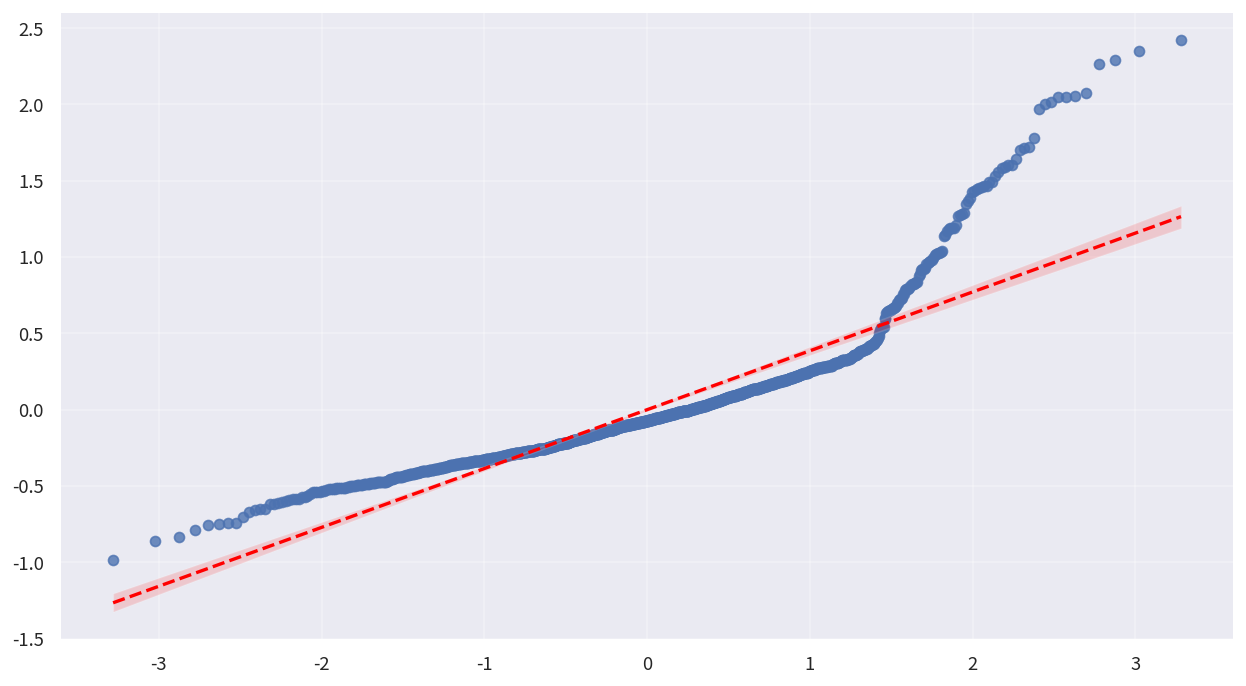

In [73]:
(x, y), _ = probplot(fit.resid)

# 1) 그래프 초기화
width_px  = 1280              # 그래프 가로 크기
height_px = 720               # 그래프 세로 크기
rows = 1                      # 그래프 행 수
cols = 1                      # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) regplot 그리기
sb.regplot(x=x, y=y, line_kws={
    "color": "red",           # 점선 색상
    "linestyle": "--",        # 점선 스타일
    "linewidth": 2            # 점선 두께
})

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)      # 배경 격자 표시

# 4) 출력
plt.tight_layout()            # 여백제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료


<잔차도 시각화>

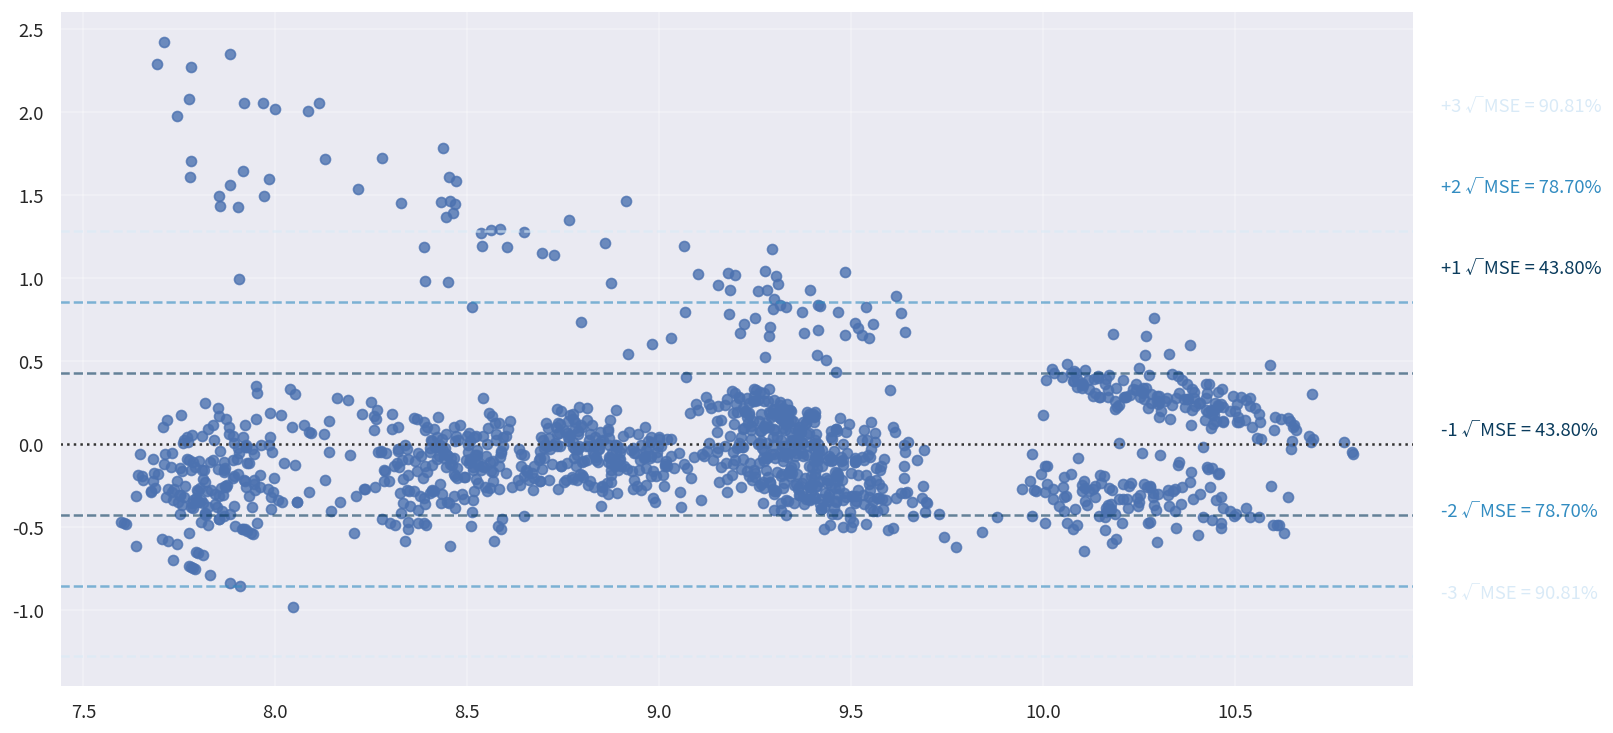

In [74]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid          # 잔차

r1 = r[(r > -mse_sq) & (r < mse_sq)].count() / r.count() * 100
r2 = r[(r > -2*mse_sq) & (r < 2*mse_sq)].count() / r.count() * 100
r3 = r[(r > -3*mse_sq) & (r < 3*mse_sq)].count() / r.count() * 100

mse_r = [r1, r2, r3]
colors = ["#0B3C5D", "#328CC1", "#D9EAF7"]

xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()

# 1) 그래프 초기화
width_px  = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi, constrained_layout=True)

# 2) seaborn 기본 잔차도
sb.residplot(x=fit.fittedvalues, y=fit.resid)

# 3) 꾸미기
ax.grid(True, alpha=0.3)

# 4) MSE 3단계 표시
for i, c in enumerate(colors):
    k = i + 1

    # 윗방향 ±k√MSE 위치
    y_pos = k * mse_root

    ax.axhline(y=y_pos,  color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)

    # 텍스트는 축 좌표계 사용 (그래프 밖으로 안 나감)
    ax.text(x=1.02, y=0.5 + 0.12*k,
            s=f"+{k} √MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)

    ax.text(x=1.02, y=0.5 - 0.12*k,
            s=f"-{k} √MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)

# 5) 출력
plt.show()
plt.close()


#### 2.잔차의 정규성 검정
잔차의 정규성이 꺠진 경우, 로그/제곱근 등 변환을 고려해야 한다

In [75]:
if len(origin) < 5000:
    method = "Shapiro-Wilk"
    stat, p = shapiro(fit.resid)
    print(f"{method} statistic: {stat:.4f}, p-value: {p:.4f}")
    violated = p < 0.05
else:
    method = "Anderson-Darling"
    ad_res = anderson(fit.resid, dist='norm')
    crit_levels = ad_res.significance_level.tolist()
    crit_values = ad_res.critical_values.tolist()
    crit_5 = crit_values[crit_levels.index(5.0)] if 5.0 in crit_levels else None
    print(f"{method} statistic: {ad_res.statistic:.4f}, 5% 임계값: {crit_5:.4f}")
    violated = crit_5 is not None and ad_res.statistic > crit_5

print("정규성 가정 위배 가능성이 있음 (5% 유의수준)" if violated else
      "정규성 가정 위배 근거 없음 (5% 유의수준)")


Shapiro-Wilk statistic: 0.8203, p-value: 0.0000
정규성 가정 위배 가능성이 있음 (5% 유의수준)


#### 3.잔차의 등분산성
표본 수가 30건보다 클 떄 중심극한정리에 따라 잔차의 등분산성이 깨지더라도 분석 겨로가에 큰 영향을 주지 않는다고 가정한다

In [76]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(fit.resid, fit.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")


Breusch–Pagan statistic: 7.145, p-value = 0.000
이분산성 존재(등분산 아님)


#### 4.잔차의 독립성

In [77]:
dw = durbin_watson(fit.resid)

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함  (자가상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음  (독립성 위반)"
else:
    interpretation = "잔차에 음(-)의 자기상관이 존재할 가능성 있음  (독립성 위반)"

print(f"Durbin-Watson: {dw:.3f}")
print(interpretation)


Durbin-Watson: 2.010
잔차는 독립성을 만족함  (자가상관 없음)


### #04.결과보고
#### 1.모형 적합도

In [78]:
m

'log_charges에 대하여 bmi,children,sex_male,smoker_yes,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64,age_group_25-34_smoker,age_group_35-44_smoker,age_group_45-64_smoker로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(12,1325) = 405.7, p < 0.05).'

#### 4.독립변수 보고

In [79]:
print("\n".join(v))

bmi의 회귀계수는 0.0136(p < 0.05)로, log_charges에 대하여 유의미한 예측변인인 것으로 나타났다.
children의 회귀계수는 0.0802(p < 0.05)로, log_charges에 대하여 유의미한 예측변인인 것으로 나타났다.
sex_male의 회귀계수는 -0.0711(p < 0.05)로, log_charges에 대하여 유의미한 예측변인인 것으로 나타났다.
smoker_yes의 회귀계수는 2.2746(p < 0.05)로, log_charges에 대하여 유의미한 예측변인인 것으로 나타났다.
region_southeast의 회귀계수는 -0.1157(p < 0.05)로, log_charges에 대하여 유의미한 예측변인인 것으로 나타났다.
region_southwest의 회귀계수는 -0.1084(p < 0.05)로, log_charges에 대하여 유의미한 예측변인인 것으로 나타났다.
age_group_25-34의 회귀계수는 0.5324(p < 0.05)로, log_charges에 대하여 유의미한 예측변인인 것으로 나타났다.
age_group_35-44의 회귀계수는 0.9118(p < 0.05)로, log_charges에 대하여 유의미한 예측변인인 것으로 나타났다.
age_group_45-64의 회귀계수는 1.4490(p < 0.05)로, log_charges에 대하여 유의미한 예측변인인 것으로 나타났다.
age_group_25-34_smoker의 회귀계수는 -0.5312(p < 0.05)로, log_charges에 대하여 유의미한 예측변인인 것으로 나타났다.
age_group_35-44_smoker의 회귀계수는 -0.8332(p < 0.05)로, log_charges에 대하여 유의미한 예측변인인 것으로 나타났다.
age_group_45-64_smoker의 회귀계수는 -1.1710(p < 0.05)로, log_charges에 대하여 유의미한 예측변인인 것으로 나타났다.


## 미션 13. “같은 나이인데 왜 의료비는 다를까?” *조 배정 후 생략


- age가 같은 두 가상의 개인을 설정하고
(예: A는 비흡연 저BMI, B는 흡연 고BMI),
다른 변수 차이로 의료비 차이를 설명한다.

비전공자에게 이야기하듯, 모델이 설명하는 것과 못하는 것을 구분해 제시한다.

- 이야기의 흐름을 “데이터 관찰 → 회귀계수 → 의료비 차이 설명” 순서로 연결한다.

예시:
“두 사람 모두 40세이지만, A는 흡연하지 않고 BMI가 25인 반면
B는 흡연자이고 BMI가 35입니다. 모델에 따르면
B의 예상 의료비는 A보다 훨씬 높습니다.
왜냐하면 흡연이 [계수]만큼 비용을 증가시키고,
BMI 1 증가가 [계수]만큼 증가시키기 때문입니다.
하지만 이 모델은 개인의 건강 이력, 유전 요인, 직업 스트레스 같은 정보는 담지 못합니다.”

모델이 설명하지 못한 요인
(개인 건강 이력, 유전 요인, 사회경제적 지위, 의료 접근성 등)의 가능성도 덧붙여
설득력을 높입니다.

📌 출제 의도
지금까지의 분석을 스토리로 엮어 설득력 있게 전달하는 마무리입니다.
모델이 말하는 것과 말하지 못하는 것을 구분해 주세요.

1. 가상의 데이터 설정 
   
| 구분    | 고객 A   | 고객 B   |
| ----- | ------ | ------ |
| 연령대   | 25–34세 | 25–34세 |
| 흡연 여부 | 비흡연    | 흡연     |
| BMI   | 22     | 24     |
| 자녀 수  | 1명     | 3명     |
| 성별    | 남성     | 여성     |


2. 모델 예측 결과
   - 종속변수: log_charges
   - 예측 의료비는 exp(log_charges)로 변환

| 고객   | 예측 log_charges | 예측 의료비 (charges) |
| ---- | -------------: | ---------------: |
| 고객 A |         8.2338 |            3,766 |
| 고객 B |        10.2432 |           28,090 |


3. 의료비 차이의 주요 원인
   
| 요인      | 고객 A  | 고객 B     | 의료비 영향                 |
| ------- | ----- | -------- | ---------------------- |
| 흡연 여부   | 비흡연   | 흡연       | 흡연은 의료비를 **배수 단위로 증가** |
| BMI     | 낮음    | 상대적으로 높음 | BMI 증가 → 의료비 증가        |
| 연령      | 동일    | 동일       | 나이 효과는 동일              |
| 흡연 × 연령 | 해당 없음 | 적용됨      | 흡연 효과가 연령대에 맞게 반영      |



4. 해석
- 두 사람 모두 25–34세이지만, A는 비흡연자이고 BMI가 22인 반면
B는 흡연자이며 BMI가 24입니다.모델에 따르면 B의 예상 의료비는 A보다 훨씬 높습니다.

- 이는 흡연이 의료비의 로그 값을 약 2.27만큼 증가시키는 강력한 요인이기 때문이며,
BMI 역시 1 증가할 때마다 의료비를 약 0.014만큼 추가로 증가시키는 효과를 갖기 때문입니다.
다만 25–34세 연령대에서는 흡연 효과가 일부 완화되어 흡연의 순효과는 약 1.74 수준으로 나타납니다.

- 그럼에도 불구하고 흡연과 BMI 상승 효과가 누적되면서 B의 예상 의료비는 A보다 약 7.5배 높게 예측되었습니다.

- 하지만 이 모델은 개인의 건강 이력, 유전적 요인, 직업 스트레스,
의료 접근성 같은 요인은 반영하지 못한다는 한계를 갖고 있습니다.



In [80]:


# 가상의 보험 고객 데이터 2개 정의
data = [
    # bmi, children, sex_male, smoker_yes, region_southeast, region_southwest,
    # age_25-34, age_35-44, age_45-64,
    # age_25-34_smoker, age_35-44_smoker, age_45-64_smoker
    [22, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],  # 25-34세, 비흡연, 남성
    [24, 3, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0]   # 25-34세, 흡연, 여성
]

# 컬럼명 정의
columns = [
    'bmi',
    'children',
    'sex_male',
    'smoker_yes',
    'region_southeast',
    'region_southwest',
    'age_group_25-34',
    'age_group_35-44',
    'age_group_45-64',
    'age_group_25-34_smoker',
    'age_group_35-44_smoker',
    'age_group_45-64_smoker'
]

# 데이터프레임 생성
df_virtual = pd.DataFrame(data, columns=columns)

# 결과 확인
print(df_virtual)


   bmi  children  sex_male  smoker_yes  region_southeast  region_southwest  \
0   22         1         1           0                 1                 0   
1   24         3         0           1                 0                 1   

   age_group_25-34  age_group_35-44  age_group_45-64  age_group_25-34_smoker  \
0                1                0                0                       0   
1                1                0                0                       1   

   age_group_35-44_smoker  age_group_45-64_smoker  
0                       0                       0  
1                       0                       0  


In [81]:


# 1) 샘플 데이터
X_virtual = df_virtual.copy()

# 2) 상수항 추가
X_virtual = sm.add_constant(X_virtual, has_constant="add")

# 3) 학습 모델이 기대하는 컬럼 순서/구성으로 맞추기 (핵심)
X_virtual = X_virtual[fit.model.exog_names]

# 4) 예측 (log_charges 예측)
pred_log = fit.predict(X_virtual)

# 5) 원래 단위(의료비)로 변환
pred_charges = np.exp(pred_log)

print("=== 가상 고객 2명에 대한 예측 결과 ===")
print(f" 고객 1 pred_log_charges: {pred_log.iloc[0]:.6f} / pred_charges: {pred_charges.iloc[0]:,.2f}")
print(f" 고객 2 pred_log_charges: {pred_log.iloc[1]:.6f} / pred_charges: {pred_charges.iloc[1]:,.2f}")

# 표로 보기
result = df_virtual.copy()
result["pred_log_charges"] = pred_log.values
result["pred_charges"] = pred_charges.values
result


=== 가상 고객 2명에 대한 예측 결과 ===
 고객 1 pred_log_charges: 8.233839 / pred_charges: 3,766.27
 고객 2 pred_log_charges: 10.243177 / pred_charges: 28,090.23


,bmi,children,sex_male,smoker_yes,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64,age_group_25-34_smoker,age_group_35-44_smoker,age_group_45-64_smoker,pred_log_charges,pred_charges
0,22,1,1,0,1,0,1,0,0,0,0,0,8.233839,3766.265409
1,24,3,0,1,0,1,1,0,0,1,0,0,10.243177,28090.234958


====================================추가분석====================================================
charges 로그 변환 없이 사분위수 각각 나눠서 진행해보기

- charges 사분위 생성

In [86]:
df_quantile = origin.copy()

df_quantile["q_group"] = pd.qcut(
    df_quantile["charges"],
    q=4,
    labels=["Q1", "Q2", "Q3", "Q4"]
)

df_quantile


,age,sex,bmi,children,smoker,region,charges,q_group
0,19,female,27.900,0,yes,southwest,16884.92400,Q4
1,18,male,33.770,1,no,southeast,1725.55230,Q1
2,28,male,33.000,3,no,southeast,4449.46200,Q1
3,33,male,22.705,0,no,northwest,21984.47061,Q4
4,32,male,28.880,0,no,northwest,3866.85520,Q1
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,Q3
1334,18,female,31.920,0,no,northeast,2205.98080,Q1
1335,18,female,36.850,0,no,southeast,1629.83350,Q1
1336,21,female,25.800,0,no,southwest,2007.94500,Q1


- 범주형 변수 더미화

In [83]:
df_reg = pd.get_dummies(
    df_quantile,
    columns=["sex", "smoker", "region"],
    drop_first=True
)


- 테이블 확인

In [84]:
df_reg

,age,bmi,children,charges,q_group,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,Q4,False,True,False,False,True
1,18,33.770,1,1725.55230,Q1,True,False,False,True,False
2,28,33.000,3,4449.46200,Q1,True,False,False,True,False
3,33,22.705,0,21984.47061,Q4,True,False,True,False,False
4,32,28.880,0,3866.85520,Q1,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,Q3,True,False,True,False,False
1334,18,31.920,0,2205.98080,Q1,False,False,False,False,False
1335,18,36.850,0,1629.83350,Q1,False,False,False,True,False
1336,21,25.800,0,2007.94500,Q1,False,False,False,False,True


- 나이 구간 추가하고, boolean 데이터 처리

In [88]:
df_reg = df_reg.copy()

age_bins = [18, 25, 35, 45, 65]
age_labels = ["18-24", "25-34", "35-44", "45-64"]

df_reg["age_group"] = pd.cut(
    df_reg["age"],
    bins=age_bins,
    labels=age_labels,
    right=False  # [18,25), [25,35) ...
)


In [89]:
df_reg = pd.get_dummies(
    df_reg,
    columns=["age_group"],
    drop_first=True  # 기준: 18–24
)


In [90]:
bool_cols = df_reg.select_dtypes(include="bool").columns

df_reg[bool_cols] = df_reg[bool_cols].astype(int)


In [102]:
df_reg

,age,bmi,children,charges,q_group,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64
0,19,27.900,0,16884.92400,Q4,0,1,0,0,1,0,0,0
1,18,33.770,1,1725.55230,Q1,1,0,0,1,0,0,0,0
2,28,33.000,3,4449.46200,Q1,1,0,0,1,0,1,0,0
3,33,22.705,0,21984.47061,Q4,1,0,1,0,0,1,0,0
4,32,28.880,0,3866.85520,Q1,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,Q3,1,0,1,0,0,0,0,1
1334,18,31.920,0,2205.98080,Q1,0,0,0,0,0,0,0,0
1335,18,36.850,0,1629.83350,Q1,0,0,0,1,0,0,0,0
1336,21,25.800,0,2007.94500,Q1,0,0,0,0,1,0,0,0


- age drop

In [104]:
df_reg_2 = df_reg.copy()
df_reg_2 = df_reg_2.drop(columns=["age"])

# 1분위수 데이터 필터
- 연속형 데이터만 넣었음 (지역 , 담배 제거..)

In [105]:
df_Q1 = df_reg_2[df_reg_2["q_group"] == "Q1"].copy()


In [106]:
corr_cols_cont = ["charges", "bmi", "children"]

corr_Q1_cont = df_Q1[corr_cols_cont].corr(method="spearman")


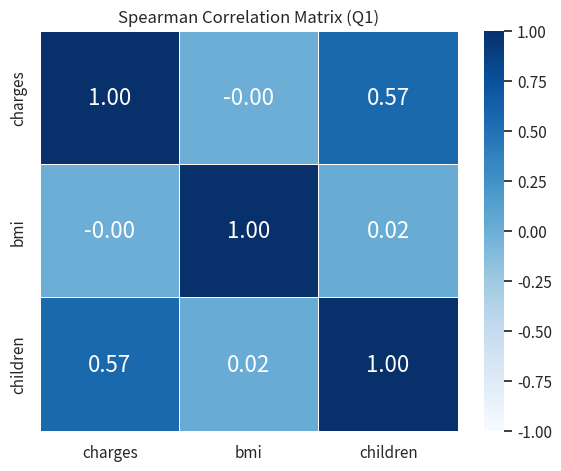

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_Q1_cont,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    vmin=-1,
    vmax=1,
    linewidths=0.5
)

plt.title("Spearman Correlation Matrix (Q1)")
plt.tight_layout()
plt.show()

- 연속형 / 범주형 변수 포함

In [108]:
corr_cols_all = [
    "charges",
    "bmi",
    "children",
    "sex_male",
    "smoker_yes",
    "region_northwest",
    "region_southeast",
    "region_southwest",
    "age_group_25-34",
    "age_group_35-44",
    "age_group_45-64",
]


corr_Q1_all = df_Q1[corr_cols_all].corr(method="spearman")


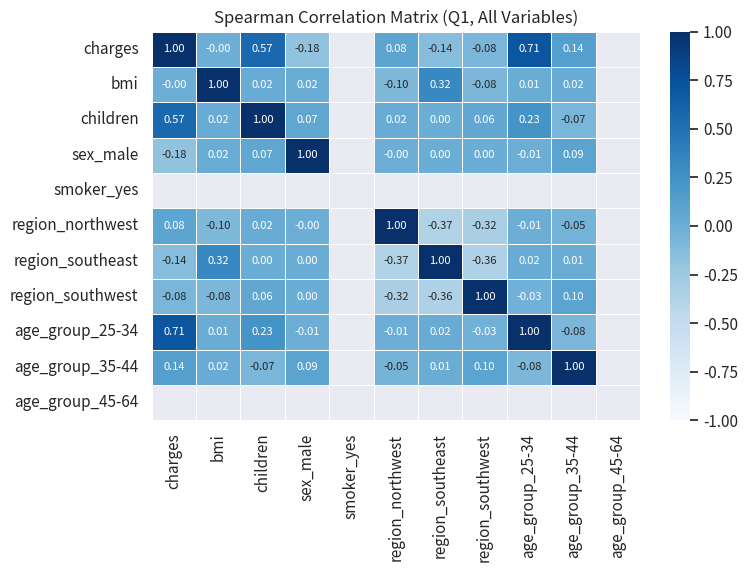

In [110]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_Q1_all,
    annot=True,
    fmt=".2f",
    cmap="Blues",     # 🔵 푸른색 계열
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    annot_kws={"size": 8} 
)

plt.title("Spearman Correlation Matrix (Q1, All Variables)")
plt.tight_layout()
plt.show()

- 다중 회귀분석 준비! 

In [112]:
df_Q1

,bmi,children,charges,q_group,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64
1,33.770,1,1725.55230,Q1,1,0,0,1,0,0,0,0
2,33.000,3,4449.46200,Q1,1,0,0,1,0,1,0,0
4,28.880,0,3866.85520,Q1,1,0,1,0,0,1,0,0
5,25.740,0,3756.62160,Q1,0,0,0,1,0,1,0,0
10,26.220,0,2721.32080,Q1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1317,53.130,0,1163.46270,Q1,1,0,0,1,0,0,0,0
1324,25.935,1,4239.89265,Q1,1,0,1,0,0,1,0,0
1334,31.920,0,2205.98080,Q1,0,0,0,0,0,0,0,0
1335,36.850,0,1629.83350,Q1,0,0,0,1,0,0,0,0


- 그냥 돌렸을 때 > BMI PVALUE 불충족

In [113]:
df_Q1_analysis_ready = df_Q1.copy()

#종속변수 설정
yname = 'charges'

#종속변수 외의 변수들 독립변수로 설정
x= df_Q1_analysis_ready.drop([yname, "q_group"],axis=1)
y=df_Q1_analysis_ready[yname]

#절편 더해주기
x_input = sm.add_constant(x)

fit = sm.OLS(y,x_input).fit()
tbl1 = fit.summary()
print(tbl1)


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     253.9
Date:                Wed, 14 Jan 2026   Prob (F-statistic):          4.36e-135
Time:                        17:33:28   Log-Likelihood:                -2474.0
No. Observations:                 335   AIC:                             4966.
Df Residuals:                     326   BIC:                             5000.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2317.1705    116.225  

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [117]:
rdf, r, m, v = ols_report(tbl1, df_Q1_analysis_ready)
display(rdf)
print(m)

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,charges,bmi,4.9411,3.698,0.029369,1.336,0.182,0.164041,6.096051
1,charges,children,565.0951,23.800,0.500173,23.744***,0.000,0.659925,1.515324
2,charges,sex_male,-450.9330,43.547,-0.214789,-10.355***,0.000,0.484508,2.063949
3,charges,smoker_yes,-8.007e-13,7.46e-14,-0.000000,-10.739***,0.000,NaN,NaN
4,charges,region_northwest,-143.0437,63.059,-0.058888,-2.268*,0.024,0.506199,1.975507
5,charges,region_southeast,-554.9287,63.854,-0.240012,-8.691***,0.000,0.395219,2.530241
6,charges,region_southwest,-552.9911,64.171,-0.224830,-8.618***,0.000,0.501083,1.995676
7,charges,age_group_25-34,1379.2639,44.609,0.648044,30.919***,0.000,0.575774,1.736794
8,charges,age_group_35-44,3018.7791,232.759,0.271196,12.970***,0.000,0.961649,1.039880
9,charges,age_group_45-64,0,0,0.000000,nan,NaN,NaN,NaN


charges에 대하여 bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age_group_25-34,age_group_35-44,age_group_45-64로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(8,326) = 253.9, p < 0.05).


- Q1 에 대해서 상호작용항 분석 진행

In [124]:

df_Q1_analysis_ready_interaction = df_Q1_analysis_ready.copy()

formula_all2 = """
charges ~ (
    bmi + children + sex_male + smoker_yes
    + region_northwest + region_southeast + region_southwest
    + Q("age_group_25-34") + Q("age_group_35-44") + Q("age_group_45-64")
)**2
"""
fit_all2 = ols(formula_all2, data=df_Q1_analysis_ready_interaction).fit()
print(fit_all2.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     76.75
Date:                Wed, 14 Jan 2026   Prob (F-statistic):          5.59e-121
Time:                        17:40:43   Log-Likelihood:                -2456.6
No. Observations:                 335   AIC:                             4971.
Df Residuals:                     306   BIC:                             5082.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [126]:
tbl_all2 = fit_all2.summary()
rdf, r, m, v = ols_report(tbl_all2, df_Q1_analysis_ready_interaction)
display(rdf)
print(m)


c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,charges,bmi,-13.2776,9.532,0.029369,-1.393,0.165,0.164041,6.096051
1,charges,children,423.3640,139.394,0.500173,3.037**,0.003,0.659925,1.515324
2,charges,sex_male,-1002.2056,236.985,-0.214789,-4.229***,0.000,0.484508,2.063949
3,charges,smoker_yes,-4.955e-12,9.27e-12,-0.000000,-0.534,0.593,NaN,NaN
4,charges,region_northwest,-221.0587,358.469,-0.058888,-0.617,0.538,0.506199,1.975507
5,charges,region_southeast,-519.7615,345.823,-0.240012,-1.503,0.134,0.395219,2.530241
6,charges,region_southwest,-885.1710,337.786,-0.224830,-2.621**,0.009,0.501083,1.995676


charges에 대하여 bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(28,306) = 76.75, p < 0.05).
